### **Installation of required packages**

In [5]:
!pip install pymupdf pandas
!pip install -q pdfplumber pandas tqdm


import re, pdfplumber, pandas as pd
from pathlib import Path
from tqdm.auto import tqdm
import json
import spacy
import re
import re
from typing import Dict
import spacy



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.1/24.1 MB 92.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 kB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.9/67.9 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.0/60.0 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 88.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 123.2 MB/s eta 0:00:00


In [7]:

from google.colab import drive
drive.mount('/content/drive')


Already unmounted
Mounted at /content/drive


### **1. PARSING OF PDFS INTO STRUCTURED CSVS AND CLEANING**

In [ ]:
# %% [markdown]
# 🔹 Stage 1-A – Extract raw question-answer rows from every PDF
#     • Installs pdfplumber
#     • Mounts Google Drive
#     • Parses each PDF in /content/drive/MyDrive/project/CB
#     • Saves stage1_raw.csv (no preprocessing yet)


PDF_DIR   = Path("/content/drive/MyDrive/project/CB")   # folder with 65 PDFs
RAW_CSV   = PDF_DIR / "stage1_raw.csv"

def parse_pdf_table(pdf_path: Path) -> pd.DataFrame:
    rows = []
    with pdfplumber.open(str(pdf_path)) as pdf:
        for page in pdf.pages:
            for table in page.extract_tables() or []:
                if not table or len(table) < 2:
                    continue
                # Skip header (row 0)
                for q, a, *_ in table[1:]:
                    q, a = (q or "").strip(), (a or "").strip()
                    if not q and not a:
                        continue
                    m = re.match(r"^(A\d+(?:\.\d+)+)", q)
                    rows.append(
                        {
                            "question_id": m.group(1) if m else None,
                            "question_text": q,
                            "answer_text":   a,
                            "file": pdf_path.name,
                        }
                    )
    return pd.DataFrame(rows)

# Parse every PDF, concatenate, save
pdfs = sorted(PDF_DIR.glob("*.pdf"))
if not pdfs:
    raise FileNotFoundError(f"No PDFs found in {PDF_DIR}")

frames = [parse_pdf_table(p) for p in pdfs]
raw_df = pd.concat(frames, ignore_index=True)

raw_df.to_csv(RAW_CSV, index=False)
print("  Saved raw merged CSV:", RAW_CSV, "\n")
display(raw_df.head(20))          # preview first 10 rows


  Saved raw merged CSV: /content/drive/MyDrive/project/CB/stage1_raw.csv 



question_id                                      question_text  \
0         None  Acceptance\nPlease read these terms and condit...   
1         A1.1  A1.1 Organisation Name\nWhat is your organisat...   
2         A1.2  A1.2 Organisation Type\nWhat type of organisat...   
3         A1.3  A1.3 Organisation Number\nWhat is your organis...   
4         A1.5  A1.5 Organisation Occupation\nWhat is your mai...   
5         A1.6  A1.6 Website Address\nWhat is your website add...   
6         A1.7  A1.7 Renewal or First Time Application\nIs thi...   
7         A1.8  A1.8 Reason for Certification\nWhat are the tw...   
8         A1.9  A1.9 CE Requirements Document\nHave you read t...   
9         A2.1  A2.1 Assessment Scope\nDoes the scope of this ...   
10        A2.3  A2.3 Geographical Location\nPlease describe th...   
11        A2.4  A2.4 End User Devices\nPlease list the quantit...   
12        A2.5  A2.5 Server Devices\nPlease list the quantity ...   
13        A2.6  A2.6 Mobile Devices\nPlease list the quantitie...   
14      A2.7.1  A2.7.1 Home Workers\nHow many staff are home w...   
15        A2.8  A2.8 Network Equipment\nPlease provide a list ...   
16       A2.10  A2.10 Responsible Person\nPlease provide the n...   
17        A3.1  A3.1 Head Office\nIs your head office domicile...   
18        A3.2  A3.2 Cyber Insurance\nIf you have answered "ye...   
19        A3.3  A3.3 Total Gross Revenue\nWhat is your total g...   

                                          answer_text             file  
0                                            I accept  answers (1).pdf  
1                                Albyn School Limited  answers (1).pdf  
2                  LTD - Limited Company (Ltd or PLC)  answers (1).pdf  
3                                            SC026743  answers (1).pdf  
4   Academia - Secondary Schools\nNotes:\nApplican...  answers (1).pdf  
5                                 www.albynschool.org  answers (1).pdf  
6                                     New Application  answers (1).pdf  
7   To Generally Improve Our Security\nNotes:\nSec...  answers (1).pdf  
8                                                 Yes  answers (1).pdf  
9                                                 Yes  answers (1).pdf  
10  A small site comprising of buildings 17, 19, 2...  answers (1).pdf  
11                                                     answers (1).pdf  
12                                                     answers (1).pdf  
13                                                     answers (1).pdf  
14  No home workers are in scope, all staff are ba...  answers (1).pdf  
15                                                     answers (1).pdf  
16  David MacDonald\nNotes:\nResponsible Person Ro...  answers (1).pdf  
17                                                Yes  answers (1).pdf  
18                                             Opt-In  answers (1).pdf  
19                                                     answers (1).pdf

In [ ]:
# %% Text-regex extractor only  ➜  stage1_raw_text.csv
# -----------------------------------------------------
!pip install -q pymupdf pandas tqdm

from google.colab import drive
drive.mount('/content/drive')

import fitz, re, os, pandas as pd
from pathlib import Path
from tqdm.auto import tqdm

PDF_DIR  = Path("/content/drive/MyDrive/project/CB")          # your PDF folder
TEXT_CSV = PDF_DIR / "stage1_raw_text.csv"                    # output file

# ── regex helpers ──────────────────────────────────────────────
BLOCK_RE = re.compile(
    r"(A\d+\.\d+[A-Za-z0-9\-]*.*?)\n(.*?)(?=\nA\d+\.\d+|\Z)", re.DOTALL
)
NOTE_RE  = re.compile(r"^\s*(Notes:|Applicant Notes:)", re.I)

def extract_text(pdf_path: Path) -> str:
    with fitz.open(str(pdf_path)) as doc:
        return "\n".join(pg.get_text() for pg in doc)

def parse_block(qid: str, blob: str) -> dict:
    lines = [l.strip() for l in blob.strip().splitlines()]
    # first blank line separates heading vs answer; if none, last line = answer
    try:
        blank = lines.index("")
    except ValueError:
        blank = len(lines) - 1
    q_text  = " ".join(lines[: blank + 1]).strip()
    ans_raw = " ".join(lines[blank + 1 :]).strip() or lines[-1].strip()

    # move Notes into answer
    notes, parts = [], []
    for seg in ans_raw.split("│") if "│" in ans_raw else [ans_raw]:
        if NOTE_RE.match(seg):
            notes.append(seg.split(":", 1)[-1].strip())
        else:
            parts.append(seg.strip())
    answer = " ".join(parts)
    if notes:
        answer = (
            f"{answer} │ Notes: {' | '.join(notes)}" if answer
            else f"Notes: {' | '.join(notes)}"
        )

    return {
        "question_id":   qid.strip(),
        "question_text": q_text,
        "answer_text":   answer,
    }

# ── run over every PDF ────────────────────────────────────────
rows = []
for fname in tqdm(sorted(os.listdir(PDF_DIR)), desc="Extracting text"):
    if fname.lower().endswith(".pdf"):
        text = extract_text(PDF_DIR / fname)
        for qid, block in BLOCK_RE.findall(text):
            rec = parse_block(qid, block)
            rec["file"] = fname
            rows.append(rec)

text_df = pd.DataFrame(rows)
text_df.to_csv(TEXT_CSV, index=False)
print(f"  Saved text extractor output → {TEXT_CSV}   (rows: {len(text_df)})")

# Preview the first 10 rows
display(text_df.head(10))


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Extracting text:   0%|          | 0/197 [00:00<?, ?it/s]

  Saved text extractor output → /content/drive/MyDrive/project/CB/stage1_raw_text.csv   (rows: 5064)


question_id  \
0                  A1.1 Organisation Name   
1                  A1.2 Organisation Type   
2                A1.3 Organisation Number   
3               A1.4 Organisation Address   
4            A1.5 Organisation Occupation   
5                    A1.6 Website Address   
6  A1.7 Renewal or First Time Application   
7           A1.8 Reason for Certification   
8           A1.9 CE Requirements Document   
9                      A1.10 Cyber Breach   

                                       question_text  \
0  What is your organisation's name? The answer g...   
1  What type of organisation are you? LTD - Limit...   
2  What is your organisation's registration numbe...   
3  What is your organisation's address? Please pr...   
4  What is your main business? Please summarise t...   
5  What is your website address? Please provide y...   
6  Is this application a renewal of an existing c...   
7  What are the two main reasons for applying for...   
8  Have you read the 'Cyber Essentials Requiremen...   
9  Can IASME and their expert partners contact yo...   

                          answer_text             file  
0                Albyn School Limited  answers (1).pdf  
1  LTD - Limited Company (Ltd or PLC)  answers (1).pdf  
2                       Answer Export  answers (1).pdf  
3             Country: United Kingdom  answers (1).pdf  
4                and Secondary School  answers (1).pdf  
5                 www.albynschool.org  answers (1).pdf  
6                     New Application  answers (1).pdf  
7                           Customers  answers (1).pdf  
8                       Answer Export  answers (1).pdf  
9                                 Yes  answers (1).pdf

In [ ]:
# %% Merge with `source` column, keep table rows in case of duplicates
# -------------------------------------------------------------------
import pandas as pd
from google.colab import drive
from pathlib import Path

drive.mount('/content/drive')

PDF_DIR   = Path("/content/drive/MyDrive/project/CB")
TABLE_CSV = PDF_DIR / "stage1_raw.csv"          # first extractor
TEXT_CSV  = PDF_DIR / "stage1_raw_text.csv"     # second extractor
OUT_CSV   = PDF_DIR / "stage1_raw_merged.csv"

# ── load & tag ------------------------------------------------------
table_df = pd.read_csv(TABLE_CSV, dtype=str).fillna("")
table_df["source"] = "table"                    # mark origin

text_df  = pd.read_csv(TEXT_CSV,  dtype=str).fillna("")
text_df["source"]  = "text"

# normalise IDs in text extractor so they match table style
text_df["question_id"] = (
    text_df["question_id"].str.extract(r"^\s*(A\d+(?:\.\d+)+)")[0].fillna("")
)
text_df = text_df[text_df["question_id"] != ""]  # drop if ID missing

# keep common column order
cols = ["file", "question_id", "question_text", "answer_text", "source"]
table_df = table_df[cols]
text_df  = text_df [cols]

# ── concatenate (table first), then drop duplicates ---------------
combined = pd.concat([table_df, text_df], ignore_index=True)

# keep the first occurrence of each (file, question_id) pair
combined_no_dupes = combined.drop_duplicates(
    subset=["file", "question_id"], keep="first"
)

# …existing code up to combined_no_dupes …

# ▶  sort by file, then question_id
combined_no_dupes = combined_no_dupes.sort_values(["file", "question_id"])

combined_no_dupes.to_csv(OUT_CSV, index=False)
print(f" merged file (sorted) → {OUT_CSV}   (rows: {len(combined_no_dupes)})")
display(combined_no_dupes.head(10))


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
 merged file (sorted) → /content/drive/MyDrive/project/CB/stage1_raw_merged.csv   (rows: 5129)


file question_id  \
0     answers (1).pdf               
1     answers (1).pdf        A1.1   
3976  answers (1).pdf       A1.10   
2     answers (1).pdf        A1.2   
3     answers (1).pdf        A1.3   
3970  answers (1).pdf        A1.4   
4     answers (1).pdf        A1.5   
5     answers (1).pdf        A1.6   
6     answers (1).pdf        A1.7   
7     answers (1).pdf        A1.8   

                                          question_text  \
0     Acceptance\nPlease read these terms and condit...   
1     A1.1 Organisation Name\nWhat is your organisat...   
3976  Can IASME and their expert partners contact yo...   
2     A1.2 Organisation Type\nWhat type of organisat...   
3     A1.3 Organisation Number\nWhat is your organis...   
3970  What is your organisation's address? Please pr...   
4     A1.5 Organisation Occupation\nWhat is your mai...   
5     A1.6 Website Address\nWhat is your website add...   
6     A1.7 Renewal or First Time Application\nIs thi...   
7     A1.8 Reason for Certification\nWhat are the tw...   

                                            answer_text source  
0                                              I accept  table  
1                                  Albyn School Limited  table  
3976                                                Yes   text  
2                    LTD - Limited Company (Ltd or PLC)  table  
3                                              SC026743  table  
3970                            Country: United Kingdom   text  
4     Academia - Secondary Schools\nNotes:\nApplican...  table  
5                                   www.albynschool.org  table  
6                                       New Application  table  
7     To Generally Improve Our Security\nNotes:\nSec...  table

### Cleaning the merged data csv

In [ ]:
import pandas as pd
import re
from pathlib import Path
import re, unicodedata

MERGED = Path("/content/drive/MyDrive/project/CB/stage1_raw_merged.csv")
df = pd.read_csv(MERGED)

# Ensure text columns are strings
df["question_text"] = df["question_text"].fillna("").astype(str)
df["answer_text"] = df["answer_text"].fillna("").astype(str)


# --- helper: unify curly/straight quotes & collapse whitespace ---
def normalise(txt: str) -> str:
    if not txt:
        return ""
    # convert curly quotes to straight ones
    tx = txt.translate({
        0x201C: '"', 0x201D: '"',  # “ ”
        0x2018: "'", 0x2019: "'",  # ‘ ’
    })
    # collapse runs of whitespace
    tx = re.sub(r'\s+', ' ', tx.strip())
    return tx


# Helper: Move only if not duplicate
def move_if_not_duplicate(source_text: str, to_move: str, target_text: str) -> (str, str):
    """Moves to_move → target_text if not already present. If present, just remove from source_text."""
    if to_move.strip() and to_move.strip() in target_text:
        return source_text.replace(to_move, "").strip(), target_text.strip()
    else:
        return source_text.replace(to_move, "").strip(), f"{to_move.strip()}\n{target_text.strip()}".strip()

# Rule 1: Move trailing "yes" or "no" at the end of question_text
def move_trailing_yes_no(row):
    qt, at = row["question_text"].strip(), row["answer_text"].strip()
    match = re.search(r"\b(yes|no)\s*$", qt, flags=re.IGNORECASE)
    if match:
        answer = match.group(1)
        qt = qt[:match.start()].strip()
        if answer.strip() not in at:
            at = f"{answer}\n{at}".strip()
    return pd.Series([qt, at])

df[["question_text", "answer_text"]] = df.apply(move_trailing_yes_no, axis=1)

# Rule 2: Move "yes"/"no" only if followed by whitespace and "notes" or nothing (strict)
def move_yes_no_and_suffix(row):
    qt, at = row["question_text"], row["answer_text"]

    # ── match "yes" or "no" followed by whitespace + "notes" / "Notes:" ──
    m = re.search(r"\b(yes|no)\b\s*notes?:", qt, flags=re.IGNORECASE)
    if not m:
        # also match if yes/no alone is the final token
        m = re.search(r"\b(yes|no)\b\s*$", qt, flags=re.IGNORECASE)
        if not m:
            return pd.Series([qt, at])

    idx = m.start()                    # start of "yes"/"no"
    block = qt[idx:].lstrip()          # everything from yes/no to the end
    qt    = qt[:idx].rstrip()          # keep text before yes/no

    # append the full block to answer_text (avoid duplication if already present)
    if normalise(block) not in normalise(at):
        at = f"{block}\n{at}".strip()

    return pd.Series([qt, at])


df[["question_text", "answer_text"]] = df.apply(move_yes_no_and_suffix, axis=1)

# Rule 3: Move text after ".pdf" to answer_text (if not duplicate)
def move_after_pdf(row):
    """
    Move everything after a '.pdf' link into answer_text **only if**
    that link is the last non-whitespace content in question_text.
    """
    qt, at = row["question_text"], row["answer_text"]

    # Find the last occurrence of ".pdf"
    m = re.search(r"(?i)(\.pdf)", qt)
    if not m:
        return pd.Series([qt, at])

    # anything after .pdf that is not just whitespace?
    after = qt[m.end():]
    if after.strip():          # there's more text → leave it in question
        return pd.Series([qt, at])

    # otherwise move the trailing bit (incl. preceding space/newline if any)
    qt_main = qt[:m.end()]          # keep the link inside question
    # (nothing actually follows .pdf here, but for symmetry we call helper)
    qt, at = move_if_not_duplicate(qt_main, "", at)
    return pd.Series([qt.strip(), at.strip()])


# Rule 4: Tail split logic per question_id — move ONLY what comes AFTER the tail to answer_text
explanatory_tails = {
    "A2.2": "whole organisation excluding development network.",
    "A2.3": "Manchester and Glasgow retail stores).",
    "A2.4": "information.",
    "A2.4.1": "Requirements-for-Infrastructure-v3-1-January-2023.pdf",
    "A2.5": "Redhat Enterprise Linux 8.3",
    "A2.6": "information.",
    "A2.7": "v3-1-January-2023.pdf",
    "A2.7.1": "v3-1-January-2023.pdf",
    "A2.8": "addresses or serial numbers.",
    "A2.9": "Requirements-for-Infrastructure-v3-1-January-2023.pdf",
    "A2.10": "IT provider.",
    "A4.1.1": "included in the operating system of their device.",
    "A4.2": "changed.",
    "A4.2.1": "achieved.",
    "A4.6": "who checks that it has been done?).",
    "A4.10": "Please explain which option is used.",
    "A4.12": "common Linux distributions such as Ubuntu do have software firewalls available.",
    "A5.1": "rpm, yum).",
    "A5.5": "Requirements-for-Infrastructure-v3-1-January-2023.pdf",
    "A5.9": "organisational data or services.",
    "A5.10": "authentication.",
    "A6.2.1": "For example: Chrome Version 102, Safari Version 15.",
    "A6.1": "Most major vendors will have published EOL dates for their operating systems and firmware.",
    "A6.2.2": "2020.",
    "A6.2.3": "For example: MS Exchange 2016, Outlook 2019.",
    "A6.2.4": "For example: MS 365; Libre office, Google workspace, Office 2016.",
    "A6.4.2": "If you only use auto updates, please confirm this in the notes field for this question.",
    "A6.5.2": "If you only use auto updates, please confirm this in the notes field for this question.",
    "A6.7": "by a firewall or VLAN.",
    "A7.1": "are only provided after they have been approved by a person with a leadership role in the business.",
    "A7.3": "When an individual leaves your organisation you need to stop them accessing any of your systems.",
    "A7.4": "folders and applications that they need to do their day to day work.",
    "A7.5": "This process might include approval by a person who is an owner/director/trustee/partner of the organisation.",
    "A7.6": "Cloud service administration must be carried out through separate accounts.",
    "A7.7": "it could be based on good policy, procedure and regular training for staff.",
    "A7.10": "v3-1-January-2023.pdf",
    "A7.11": "v3-1-January-2023.pdf",
    "A7.12": "v3-1-January-2023.pdf",
    "A4.9": "be documented (for example, written down).",
    "A4.1": "network and the internet.",
    "A4.3": "Requirements-for-Infrastructure-v3-1-January-2023.pdf",
    "A4.4": "the password to access the device will need to be changed.",
    "A4.4": "the password to access the device will need to be changed.",
    "A4.5": "most firewalls block all services.",
    "A4.7": "you need to check your firewall settings.",
    "A5.2": "3. Linux using ""cat /etc/passwd""",
    "A5.4": "not want to be publicly accessible.",
    "A5.7": "hope of gaining access.",
    "A5.8": "chosen this option, you can answer yes to this question.",
    "A5.9": "organisational data or services.",
    "A6.1": "their operating systems and firmware.",
    "A6.2": "such as Java, Adobe Reader and .NET.",
    "A6.3": "purchased, they will not be receiving regular security updates.",
    "A6.4": "This requirement includes the firmware on your firewalls and routers.",
    "A6.4.1": "This must be enabled on any device where possible.",
    "A6.5": "high-risk or critical security updates.",
    "A6.5.1": "Auto updates should be enabled where possible.",
    "A6.6": "Java and Flash, and all application software.",
    "A7.2": "Accounts must not be shared.",
    "A7.8": "You must track all people that have been granted administrator accounts.",
    "A7.9": "Any users whono longer need administrative access to carry out their role should have it removed.",
    "A7.14": "linked to are Azure, MS365, Google Workspace.",
    "A7.16": "conjunction with a password of at least 8 characters.",
    "A7.17": "conjunction with a password of at least 8 characters.",
    "A8.1": " explanation notes will be required.",
    "A8.2": "doubt, Windows Defender is suitable for this purpose.",
    "A8.3": " access to known malicious websites. On Windows 10, SmartScreen can provide this functionality.",
    "A8.4": "a device to allow unsigned applications.",
    "A8.5": "using good policy, processes and training of staff.",
    "A4.5.1": "level and associated risks reviewed regularly.",
    "A1.10": "information will be kept confidential.",
    "A5.2": '3. Linux using ""cat /etc/passwd""',
    "A4.11": '"Windows firewall". On Linux try "ufw status".',
    "A5.3":  'Sequences such as "12345".',


}

def move_explanatory_tail(row):
    qid, qt, at = row["question_id"], row["question_text"], row["answer_text"]
    if pd.notna(qid) and qid in explanatory_tails:
        tail = explanatory_tails[qid].strip()
        idx = qt.find(tail)
        if idx != -1:
            tail_end = idx + len(tail)
            after_tail = qt[tail_end:].strip()
            qt = qt[:tail_end].strip()  # Keep tail in question_text
            if after_tail:
                qt, at = move_if_not_duplicate(qt + " " + after_tail, after_tail, at)
    return pd.Series([qt.strip(), at.strip()])

df[["question_text", "answer_text"]] = df.apply(move_explanatory_tail, axis=1)

def move_first_word_if_tail_or_pdf(row):
    qt, at = row["question_text"].strip(), row["answer_text"].strip()
    qid = row["question_id"]

    if not at or not pd.notna(qid):
        return pd.Series([qt, at])

    first_token = at.strip().split()[0]
    if qid in explanatory_tails:
        tail_last_word = explanatory_tails[qid].strip().split()[-1]
        if first_token == tail_last_word or first_token.lower().endswith(".pdf"):
            if first_token not in qt:
                qt = f"{qt.strip()} {first_token}".strip()
            at = " ".join(at.strip().split()[1:]).strip()

    return pd.Series([qt, at])


# Apply tail suffix match from start of answer_text
df[["question_text", "answer_text"]] = df.apply(move_first_word_if_tail_or_pdf, axis=1)



# --- delete any sentence in answer_text that matches tail exactly ---
def drop_exact_tail_sentence(row):
    qid, at = row["question_id"], row["answer_text"]
    if qid not in explanatory_tails or not at.strip():
        return pd.Series([row["question_text"], at])

    tail_norm = normalise(explanatory_tails[qid])
    at_norm   = normalise(at)

    # case 1: answer is *only* the tail
    if at_norm == tail_norm:
        return pd.Series([row["question_text"], ""])

    # case 2: answer has multiple sentences – remove the one(s) equal to tail
    sent_split = re.split(r'(?<=[.!?])\s+', at.strip())
    kept = [s for s in sent_split if normalise(s) and normalise(s) != tail_norm]
    new_at = " ".join(kept).strip()
    return pd.Series([row["question_text"], new_at])

# apply the drop-tail rule
df[["question_text", "answer_text"]] = df.apply(drop_exact_tail_sentence, axis=1)


# Save cleaned output
output_path = "/content/drive/MyDrive/project/CB/stage1_cleaned_questions.csv"
df.to_csv(output_path, index=False)

# remove NaN values
df["answer_text"] = df["answer_text"].fillna("")


# Preview first 10 rows
from IPython.display import display
display(df.head(10))

file question_id  \
0  answers (1).pdf         NaN   
1  answers (1).pdf        A1.1   
2  answers (1).pdf       A1.10   
3  answers (1).pdf        A1.2   
4  answers (1).pdf        A1.3   
5  answers (1).pdf        A1.4   
6  answers (1).pdf        A1.5   
7  answers (1).pdf        A1.6   
8  answers (1).pdf        A1.7   
9  answers (1).pdf        A1.8   

                                       question_text  \
0  Acceptance\nPlease read these terms and condit...   
1  A1.1 Organisation Name\nWhat is your organisat...   
2  Can IASME and their expert partners contact yo...   
3  A1.2 Organisation Type\nWhat type of organisat...   
4  A1.3 Organisation Number\nWhat is your organis...   
5  What is your organisation's address? Please pr...   
6  A1.5 Organisation Occupation\nWhat is your mai...   
7  A1.6 Website Address\nWhat is your website add...   
8  A1.7 Renewal or First Time Application\nIs thi...   
9  A1.8 Reason for Certification\nWhat are the tw...   

                                         answer_text source  
0                                           I accept  table  
1                               Albyn School Limited  table  
2                                                Yes   text  
3                 LTD - Limited Company (Ltd or PLC)  table  
4                                           SC026743  table  
5                            Country: United Kingdom   text  
6  Academia - Secondary Schools\nNotes:\nApplican...  table  
7                                www.albynschool.org  table  
8                                    New Application  table  
9  To Generally Improve Our Security\nNotes:\nSec...  table

### Checking if yes_no questions mapped correctly

In [ ]:
import pandas as pd

# Define the target question IDs
target_ids = [
    "A1.9", "A1.10", "A2.1", "A4.1", "A4.2", "A4.4", "A4.5", "A4.5.1",
    "A4.7", "A4.8", "A4.9", "A4.11", "A5.2", "A5.3", "A5.4", "A5.8", "A5.9",
    "A6.1", "A6.2", "A6.3", "A6.4", "A6.4.1", "A6.5", "A6.5.1", "A6.6",
    "A7.2", "A8.2", "A8.3", "A8.4", "A8.5", "A7.16", "A7.17"
]

# Filter the dataframe
filtered = df[
    df["question_id"].isin(target_ids) &  # Only target IDs
    df["answer_text"].str.strip().ne("") &  # Not blank
    ~df["answer_text"].str.lower().str.contains(r"\byes\b|\bno\b")  # Neither "yes" nor "no"
]

# Show the first 20 results
from IPython.display import display
display(filtered.head(20))

Empty DataFrame
Columns: [file, question_id, question_text, answer_text, source]
Index: []

### Checking if multiple choice questions mapped correctly

In [ ]:



# Define the target question IDs
target_ids = ["A5.5", "A4.3", "A5.7", "A8.1"]

# Filter for those question_ids
subset = df[df["question_id"].isin(target_ids)]

# Keep only rows where answer_text is NOT blank
subset = subset[subset["answer_text"].str.strip() != ""]

# Now check if 'answer_text' does NOT start with A., B., C., or D.
invalid_start = ~subset["answer_text"].str.strip().str.startswith(tuple("ABCDabcd"), na=False)

# Final filtered rows
invalid_rows = subset[invalid_start]

# Display the result
print(f"⚠️ Found {len(invalid_rows)} rows where answer_text is non-empty but does NOT start with A./B./C./D.:")
display(invalid_rows[["file", "question_id", "question_text", "answer_text"]])


⚠️ Found 0 rows where answer_text is non-empty but does NOT start with A./B./C./D.:


Empty DataFrame
Columns: [file, question_id, question_text, answer_text]
Index: []

### checking answers with single words

In [ ]:
# Normalize answer_text
df["answer_text"] = df["answer_text"].fillna("").astype(str).str.strip()

# Define filter: single word, not yes/no, not blank
single_word_answers = df[
    df["answer_text"].apply(lambda x: len(x.split()) == 1 and x.lower() not in ["yes", "no"] and x.strip() != "")
]

# Display first 20 matching rows
from IPython.display import display
display(single_word_answers.head(20))

file question_id  \
4     answers (1).pdf        A1.3   
7     answers (1).pdf        A1.6   
23    answers (1).pdf        A3.2   
87   answers (10).pdf        A1.3   
89   answers (10).pdf        A1.5   
90   answers (10).pdf        A1.6   
96   answers (10).pdf        A2.3   
102  answers (10).pdf      A2.7.1   
106  answers (10).pdf        A3.2   
107  answers (10).pdf        A3.3   
108  answers (10).pdf        A3.4   
166  answers (11).pdf        A1.3   
168  answers (11).pdf        A1.5   
177  answers (11).pdf      A2.4.1   
178  answers (11).pdf        A2.5   
181  answers (11).pdf      A2.7.1   
185  answers (11).pdf        A3.2   
186  answers (11).pdf        A3.3   
187  answers (11).pdf        A3.4   
243  answers (12).pdf        A1.3   

                                         question_text  \
4    A1.3 Organisation Number\nWhat is your organis...   
7    A1.6 Website Address\nWhat is your website add...   
23   A3.2 Cyber Insurance\nIf you have answered "ye...   
87   A1.3 Organisation Number\nWhat is your organis...   
89   A1.5 Organisation Occupation\nWhat is your mai...   
90   A1.6 Website Address\nWhat is your website add...   
96   A2.3 Geographical Location\nPlease describe th...   
102  A2.7.1 Home Workers\nHow many staff are home w...   
106  A3.2 Cyber Insurance\nIf you have answered "ye...   
107  A3.3 Total Gross Revenue\nWhat is your total g...   
108  What is the organisation email contact for the...   
166  A1.3 Organisation Number\nWhat is your organis...   
168  A1.5 Organisation Occupation\nWhat is your mai...   
177  Please list the quantity of thin clients withi...   
178  A2.5 Server Devices\nPlease list the quantity ...   
181  A2.7.1 Home Workers\nHow many staff are home w...   
185  A3.2 Cyber Insurance\nIf you have answered "ye...   
186  A3.3 Total Gross Revenue\nWhat is your total g...   
187  What is the organisation email contact for the...   
243  A1.3 Organisation Number\nWhat is your organis...   

                  answer_text source  
4                    SC026743  table  
7         www.albynschool.org  table  
23                     Opt-In  table  
87                   OC352969  table  
89                      Legal  table  
90             comptons.co.uk  table  
96                     London  table  
102                        36  table  
106                    Opt-In  table  
107                £5,000,000  table  
108         sc@comptons.co.uk   text  
166                  14503858  table  
168               Consultancy  table  
177                         0   text  
178                         0  table  
181                         1  table  
185                    Opt-In  table  
186                     £300k  table  
187  paul@consult-first.co.uk   text  
243                  03297951  table

### **2. PREPARATION OF DATA FOR MANUAL ANNOTATIONS**

In [ ]:
import pandas as pd
from IPython.display import display

# Load the CSV
df = pd.read_csv("/content/drive/MyDrive/project/CB/stage1_raw_merged.csv")

# Remove the 'source' column if it exists
if 'source' in df.columns:
    df.drop(columns=['source'], inplace=True)

# Drop rows where 'question_id' is NaN or blank
df = df[df['question_id'].notna()]                   # remove NaNs
df = df[df['question_id'].astype(str).str.strip() != ""]  # remove empty strings

# Add a new 'compliance' column with empty values
df['compliance'] = ""

# Save the new dataframe to CSV
output_path = "/content/drive/MyDrive/project/CB/manual_null_compliance.csv"
df.to_csv(output_path, index=False)

# Display the first 10 rows
display(df.head(10))


file question_id  \
1   answers (1).pdf        A1.1   
2   answers (1).pdf       A1.10   
3   answers (1).pdf        A1.2   
4   answers (1).pdf        A1.3   
5   answers (1).pdf        A1.4   
6   answers (1).pdf        A1.5   
7   answers (1).pdf        A1.6   
8   answers (1).pdf        A1.7   
9   answers (1).pdf        A1.8   
10  answers (1).pdf        A1.9   

                                        question_text  \
1   A1.1 Organisation Name\nWhat is your organisat...   
2   Can IASME and their expert partners contact yo...   
3   A1.2 Organisation Type\nWhat type of organisat...   
4   A1.3 Organisation Number\nWhat is your organis...   
5   What is your organisation's address? Please pr...   
6   A1.5 Organisation Occupation\nWhat is your mai...   
7   A1.6 Website Address\nWhat is your website add...   
8   A1.7 Renewal or First Time Application\nIs thi...   
9   A1.8 Reason for Certification\nWhat are the tw...   
10  A1.9 CE Requirements Document\nHave you read t...   

                                          answer_text compliance  
1                                Albyn School Limited             
2                                                 Yes             
3                  LTD - Limited Company (Ltd or PLC)             
4                                            SC026743             
5                             Country: United Kingdom             
6   Academia - Secondary Schools\nNotes:\nApplican...             
7                                 www.albynschool.org             
8                                     New Application             
9   To Generally Improve Our Security\nNotes:\nSec...             
10                                                Yes

In [ ]:
import pandas as pd
from IPython.display import display

# Load the original CSV
df = pd.read_csv("/content/drive/MyDrive/project/CB/stage1_raw_merged.csv")

# Remove the 'source' column if it exists
if 'source' in df.columns:
    df.drop(columns=['source'], inplace=True)

# Drop rows with missing or blank 'question_id'
df = df[df['question_id'].notna()]
df = df[df['question_id'].astype(str).str.strip() != ""]

# Add a blank 'compliance' column
df['compliance'] = ""

# Keep only required columns: file, question_id, compliance
df_filtered = df[['file', 'question_id', 'compliance']]

# Save the filtered DataFrame
output_path = "/content/drive/MyDrive/project/CB/manual_marking.csv"
df_filtered.to_csv(output_path, index=False)

# Display first 10 rows for confirmation
display(df_filtered.head(10))


file question_id compliance
1   answers (1).pdf        A1.1           
2   answers (1).pdf       A1.10           
3   answers (1).pdf        A1.2           
4   answers (1).pdf        A1.3           
5   answers (1).pdf        A1.4           
6   answers (1).pdf        A1.5           
7   answers (1).pdf        A1.6           
8   answers (1).pdf        A1.7           
9   answers (1).pdf        A1.8           
10  answers (1).pdf        A1.9

I created a simplified annotation file (manual_marking.csv) that only includes the file, question_id, and an empty compliance column. I removed the question_text because I’m already reading the full questions and answers directly from the original PDF files, so I don’t need to duplicate that in the CSV.

This makes it easier for me to manually mark each application form one at a time. For example, when I open answers (1).pdf, I scroll through the questions, and for each one (e.g., A1.1, A1.2), I enter the compliance label — like "Compliant" or "Non-Compliant" — directly into the CSV under the right row.

Later on, once I’ve annotated all the forms, I plan to merge these labels back into the full dataset using file and question_id as keys. That way, I’ll have the full data (question, answer, compliance) ready for model training or evaluation.

This script below updates the full question dataset (manual_null_compliance.csv) by merging in manually annotated compliance labels from a simpler marking file (manual_marking.csv). It uses the combination of file and question_id as a unique identifier to match and apply the correct compliance status. The result is saved as manual_nnotated_questions.csv, which now includes the updated compliance labels ready for analysis or model training.

In [ ]:
import pandas as pd

# Load source of truth (with compliance column)
ann_path = "/content/drive/MyDrive/project/CB/manual_marking.csv"
mark_path = "/content/drive/MyDrive/project/CB/manual_null_compliance.csv"
outpath= "/content/drive/MyDrive/project/CB/manual_nnotated_questions.csv"

# Load the data
df_ann = pd.read_csv(ann_path, dtype=str).fillna("")
df_mark = pd.read_csv(mark_path, dtype=str).fillna("")

# Build a mapping from (file, question_id) to compliance
compliance_map = df_ann.set_index(['file', 'question_id'])['compliance'].to_dict()

# Function to update compliance if match found
def update_compliance(row):
    key = (row['file'], row['question_id'])
    return compliance_map.get(key, row.get('compliance', ""))

df_mark['compliance'] = df_mark.apply(update_compliance, axis=1)

# Save back to file
df_mark.to_csv(outpath, index=False)
print(f"✅ Updated compliance labels in: {outpath}")
# Show the first 10 rows
display(df_mark.head(10))

✅ Updated compliance labels in: /content/drive/MyDrive/project/CB/manual_nnotated_questions.csv


file question_id  \
0  answers (1).pdf        A1.1   
1  answers (1).pdf       A1.10   
2  answers (1).pdf        A1.2   
3  answers (1).pdf        A1.3   
4  answers (1).pdf        A1.4   
5  answers (1).pdf        A1.5   
6  answers (1).pdf        A1.6   
7  answers (1).pdf        A1.7   
8  answers (1).pdf        A1.8   
9  answers (1).pdf        A1.9   

                                       question_text  \
0  A1.1 Organisation Name\nWhat is your organisat...   
1  Can IASME and their expert partners contact yo...   
2  A1.2 Organisation Type\nWhat type of organisat...   
3  A1.3 Organisation Number\nWhat is your organis...   
4  What is your organisation's address? Please pr...   
5  A1.5 Organisation Occupation\nWhat is your mai...   
6  A1.6 Website Address\nWhat is your website add...   
7  A1.7 Renewal or First Time Application\nIs thi...   
8  A1.8 Reason for Certification\nWhat are the tw...   
9  A1.9 CE Requirements Document\nHave you read t...   

                                         answer_text compliance  
0                               Albyn School Limited  Compliant  
1                                                Yes  Compliant  
2                 LTD - Limited Company (Ltd or PLC)  Compliant  
3                                           SC026743  Compliant  
4                            Country: United Kingdom  Compliant  
5  Academia - Secondary Schools\nNotes:\nApplican...  Compliant  
6                                www.albynschool.org  Compliant  
7                                    New Application  Compliant  
8  To Generally Improve Our Security\nNotes:\nSec...  Compliant  
9                                                Yes  Compliant

### **3. EXPLORATION OF MANUAL ANNOTATED DATA**

### Number of application forms labelled

In [ ]:
import pandas as pd

CSV_PATH = "/content/drive/MyDrive/project/CB/manual_annotated_questions.csv"
df = pd.read_csv(CSV_PATH, dtype=str).fillna("")

# Count unique files
unique_files = df["file"].nunique()
print(f"Number of unique application forms (files): {unique_files}")

# Optionally, display the file names (first 10)
print("\nSample of unique file names:")
print(df["file"].unique()[:10])


Number of unique application forms (files): 65

Sample of unique file names:
['answers (1).pdf' 'answers (10).pdf' 'answers (11).pdf'
 'answers (12).pdf' 'answers (13).pdf' 'answers (14).pdf'
 'answers (15).pdf' 'answers (16).pdf' 'answers (17).pdf'
 'answers (18).pdf']


### check if are not duplicates

In [ ]:
import pandas as pd

CSV_PATH = "/content/drive/MyDrive/project/CB/manual_annotated_questions.csv"
df = pd.read_csv(CSV_PATH, dtype=str).fillna("")

# Count duplicates: same file + question_id
dupes = df.duplicated(subset=["file", "question_id"], keep=False)
n_dupes = dupes.sum()

if n_dupes == 0:
    print("✅ No duplicate (file, question_id) pairs found. Each form has only one answer per question.")
else:
    print(f" Found {n_dupes} duplicate (file, question_id) rows. Here are the first few:")
    print(df.loc[dupes, ["file", "question_id", "answer_text"]].head(10))


✅ No duplicate (file, question_id) pairs found. Each form has only one answer per question.


In [ ]:
df_a1_1 = df[df["question_id"] == "A1.1"]
print(df_a1_1[["file", "answer_text"]].head(10))


                 file                              answer_text
0     answers (1).pdf                     Albyn School Limited
82   answers (10).pdf                  Comptons Solicitors LLP
160  answers (11).pdf                        Consult First Ltd
236  answers (12).pdf                    Crewit Resourcing LTD
315  answers (13).pdf  Cunninghame Housing Association Limited
394  answers (14).pdf             DISCOVERY HOMES (DUNDEE) LTD
473  answers (15).pdf                   Dron & Dickson Limited
544  answers (16).pdf                 Edward Connor Solicitors
622  answers (17).pdf                               FDT GB Ltd
701  answers (18).pdf                       Glenalmond College


In [ ]:
# Filter for A1.1 only
df_a1_1 = df[df["question_id"] == "A1.1"]

# Check for duplicate answer_texts for A1.1 (across different files)
dupe_answers = df_a1_1.duplicated(subset=["answer_text"], keep=False)
n_dupe_answers = dupe_answers.sum()

if n_dupe_answers == 0:
    print("✅ All A1.1 answers are unique across forms.")
else:
    print(f" Found {n_dupe_answers} A1.1 answers that are repeated across forms. Sample of first 10:")
    dupes_df = df_a1_1.loc[dupe_answers, ["file", "answer_text"]]
    print(dupes_df.head(10))
    print("\nDistinct repeated answers in first 10 shown above:")
    print(dupes_df['answer_text'].head(10).tolist())


✅ All A1.1 answers are unique across forms.


In [ ]:
import pandas as pd

# Load your data
CSV_PATH = "/content/drive/MyDrive/project/CB/manual_annotated_questions.csv"
df = pd.read_csv(CSV_PATH, dtype=str).fillna("")

unique_count = df["question_id"].nunique()
print(f"Total unique question IDs: {unique_count}")


Total unique question IDs: 92


### Coverage of Question IDs Across All Forms

In [ ]:
import pandas as pd

# Load your data
CSV_PATH = "/content/drive/MyDrive/project/CB/manual_annotated_questions.csv"
df = pd.read_csv(CSV_PATH, dtype=str).fillna("")

# Count how many distinct forms each question_id appears in
qid_form_counts = df.groupby("question_id")["file"].nunique()

# Get total number of forms
total_forms = df["file"].nunique()
print(f"Total forms: {total_forms}")

# Count question_ids that appear in ALL forms
appear_in_all = (qid_form_counts == total_forms).sum()

# Count question_ids that do NOT appear in all forms
not_in_all = (qid_form_counts != total_forms).sum()

print(f"Question IDs appearing in ALL {total_forms} forms: {appear_in_all}")
print(f"Question IDs NOT appearing in all forms: {not_in_all}")

# Optional: list them
qids_in_all = qid_form_counts[qid_form_counts == total_forms].index.tolist()
qids_not_in_all = qid_form_counts[qid_form_counts != total_forms].index.tolist()



Total forms: 65
Question IDs appearing in ALL 65 forms: 70
Question IDs NOT appearing in all forms: 22


### Occurrence counts per question_id

In [ ]:
import pandas as pd

# Load your data
CSV_PATH = "/content/drive/MyDrive/project/CB/manual_annotated_questions.csv"
df = pd.read_csv(CSV_PATH, dtype=str).fillna("")

# Pivot table: question_id as rows, compliance labels as columns
pivot = (
    df.pivot_table(index="question_id", columns="compliance", values="file", aggfunc="count", fill_value=0)
      .reset_index()
)

# Add a total count column
pivot["total_occurrences"] = pivot.drop(columns=["question_id"]).sum(axis=1)

# Sort by total_occurrences ascending, then by question_id
pivot_sorted = pivot.sort_values(by=["total_occurrences", "question_id"], ascending=[True, True])

# Show the 20 lowest
display(pivot_sorted.head(22))



compliance question_id  Compliant  Fail  More-information  Non-Compliant  \
34               A4.12          0     0                 0              1   
76               A7.15          1     0                 0              0   
11              A1.8.4          2     0                 0              0   
12              A1.8.5          3     0                 0              0   
9               A1.8.1          6     0                 0              0   
10              A1.8.2          7     0                 0              0   
16                A2.2          0     0                 2              5   
32               A4.10          8     1                 0              2   
44                A4.9         10     0                 0              1   
50                A5.5         14     0                 0              0   
51                A5.6         13     0                 0              1   
52                A5.7         13     1                 0              0   
40              A4.5.1         21     1                 0              0   
41                A4.6         19     0                 0              3   
28                A3.3         27     1                 0              0   
29                A3.4         28     0                 0              0   
27                A3.2         44     0                 0              0   
90                A8.4         50     0                 0              1   
91                A8.5         51     0                 0              0   
26                A3.1         54     3                 0              0   
88                A8.2         59     1                 0              0   
89                A8.3         59     1                 0              0   

compliance  total_occurrences  
34                          1  
76                          1  
11                          2  
12                          3  
9                           6  
10                          7  
16                          7  
32                         11  
44                         11  
50                         14  
51                         14  
52                         14  
40                         22  
41                         22  
28                         28  
29                         28  
27                         44  
90                         51  
91                         51  
26                         57  
88                         60  
89                         60

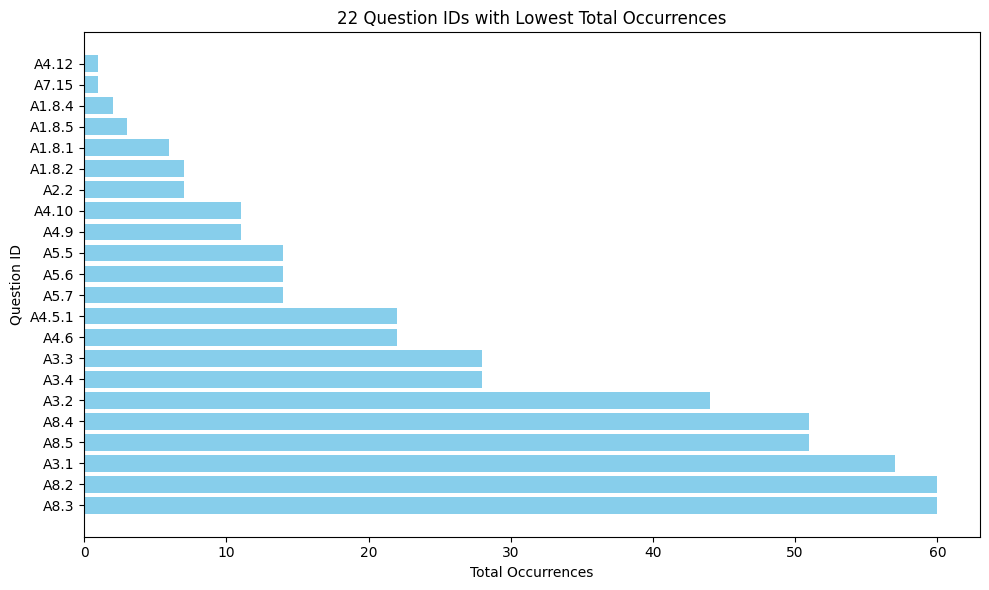

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load data
CSV_PATH = "/content/drive/MyDrive/project/CB/manual_annotated_questions.csv"
df = pd.read_csv(CSV_PATH, dtype=str).fillna("")

# Pivot table
pivot = (
    df.pivot_table(index="question_id", columns="compliance", values="file", aggfunc="count", fill_value=0)
      .reset_index()
)

# Total occurrences
pivot["total_occurrences"] = pivot.drop(columns=["question_id"]).sum(axis=1)

# Sort and pick lowest 20
pivot_sorted = pivot.sort_values(by=["total_occurrences", "question_id"], ascending=[True, True]).head(22)

# Plot
plt.figure(figsize=(10, 6))
plt.barh(pivot_sorted["question_id"], pivot_sorted["total_occurrences"], color="skyblue")
plt.xlabel("Total Occurrences")
plt.ylabel("Question ID")
plt.title("22 Question IDs with Lowest Total Occurrences")
plt.gca().invert_yaxis()  # Highest bar on top
plt.tight_layout()
plt.show()


### Analysis per question_types

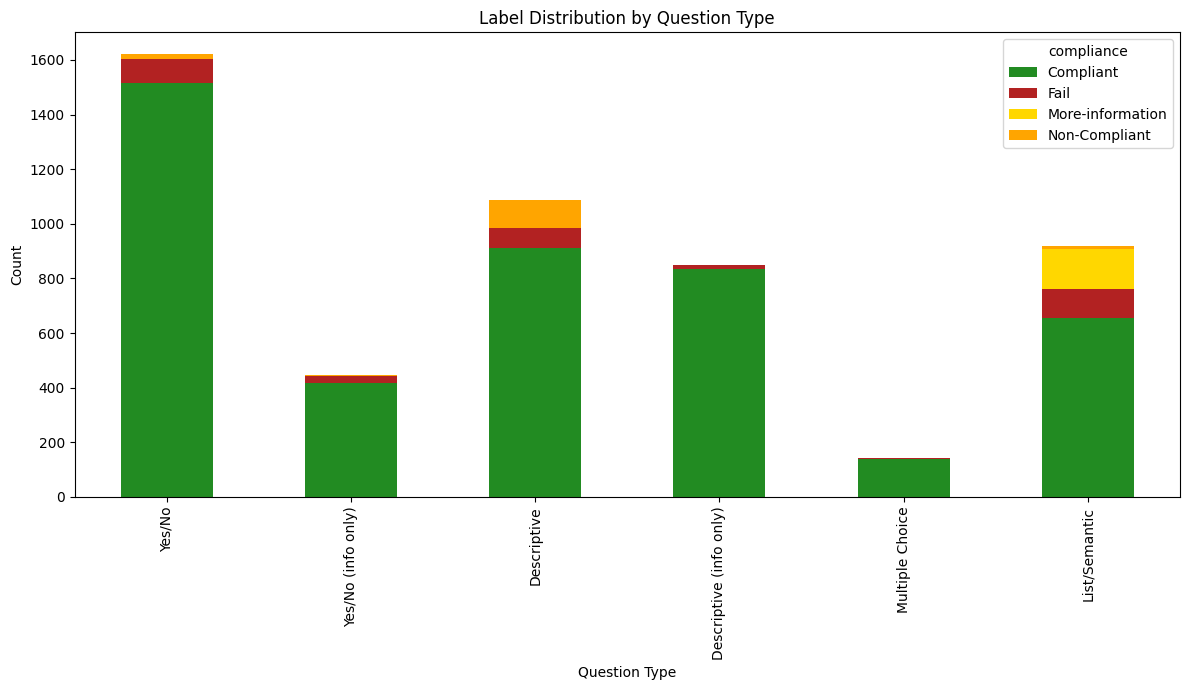

compliance               Compliant  Fail  More-information  Non-Compliant
qtype                                                                    
Yes/No                        1514    88                 0             18
Yes/No (info only)             419    25                 0              3
Descriptive                    913    71                 0            103
Descriptive (info only)        835    13                 0              0
Multiple Choice                140     4                 0              0
List/Semantic                  657   104               148              9


In [ ]:
yes_no_ids = {
    "A4.1","A4.2","A4.4","A4.7","A4.9",
    "A5.2","A5.3","A5.8","A5.9",
    "A6.1","A6.2","A6.3","A6.4","A6.5","A6.6",
    "A7.2","A7.8","A7.9","A7.13","A7.16","A7.17",
    "A1.9","A8.2","A8.3","A8.4","A8.5","A7.5","A4.5.1"
}
yes_no_info_only_ids = {"A4.5", "A7.14"} | {"A2.1","A3.1","A4.8","A4.11","A5.4"}  # Accept No + Non-scoring
descriptive_info_only_ids = {
    "A1.1","A1.2","A1.3","A1.4","A1.5","A1.6","A1.7",
    "A1.8","A1.8.1","A1.8.2","A1.8.3","A1.8.4","A1.8.5",
    "A1.10",
    "A3.1","A3.2","A3.3","A3.4",
    "A4.11",
    "A5.7",
    "A6.4.1","A6.5.1","A1.11","A7.15"
}
multiple_choice_ids = {"A4.3", "A5.5", "A8.1"}

semantic_ids = {
    "A2.2","A2.10","A2.3","A2.4","A2.4.1","A2.5","A2.6","A2.7","A2.7.1","A2.8","A2.9",
    "A4.12","A6.2.1","A6.2.2","A6.2.3","A6.2.4"
}
descriptive_ids = {
    "A4.1.1", "A4.10", "A4.2.1", "A4.6", "A5.1", "A5.10", "A5.6",
    "A6.4.2", "A6.5.2", "A6.7", "A7.1", "A7.10", "A7.11", "A7.12",
    "A7.3", "A7.4", "A7.5", "A7.6", "A7.7"
}

def qtype(qid):
    if qid in semantic_ids:
        return "List/Semantic"
    if qid in descriptive_ids:
        return "Descriptive"
    if qid in multiple_choice_ids:
        return "Multiple Choice"
    if qid in yes_no_ids:
        return "Yes/No"
    if qid in yes_no_info_only_ids:
        return "Yes/No (info only)"
    if qid in descriptive_info_only_ids:
        return "Descriptive (info only)"
    return "Other"


df["qtype"] = df["question_id"].map(qtype)

import matplotlib.pyplot as plt

type_pivot = pd.pivot_table(
    df, index="qtype", columns="compliance", aggfunc="size", fill_value=0
)

type_pivot = type_pivot.loc[
    ["Yes/No", "Yes/No (info only)", "Descriptive", "Descriptive (info only)", "Multiple Choice", "List/Semantic"]
]  # order for plot

type_pivot.plot(
    kind="bar", stacked=True, figsize=(12,7),
    color=["forestgreen","firebrick","gold","orange"],
    title="Label Distribution by Question Type"
)
plt.ylabel("Count")
plt.xlabel("Question Type")
plt.tight_layout()
plt.show()

print(type_pivot)


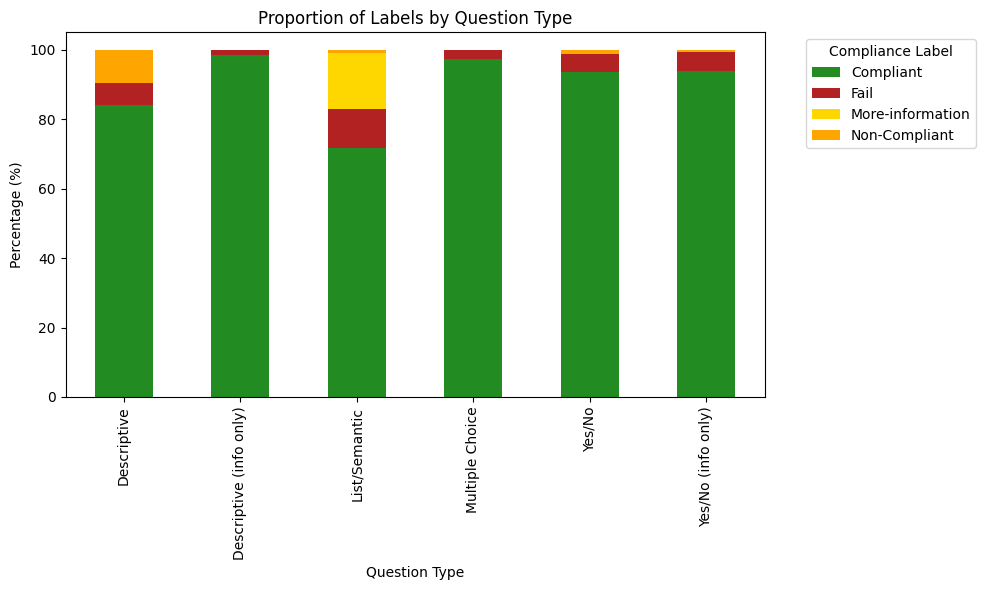

In [ ]:
import matplotlib.pyplot as plt

# --- Prepare percentage pivot table ---
type_counts = df.groupby('qtype')['compliance'].value_counts().unstack(fill_value=0)
type_percent = type_counts.div(type_counts.sum(axis=1), axis=0) * 100

# --- Stacked bar plot of proportions ---
ax = type_percent.plot(
    kind="bar", stacked=True, figsize=(10,6),
    color=["forestgreen","firebrick","gold","orange"],
    title="Proportion of Labels by Question Type"
)
plt.ylabel("Percentage (%)")
plt.xlabel("Question Type")
plt.legend(title="Compliance Label", bbox_to_anchor=(1.05,1))
plt.tight_layout()
plt.show()


Typical number of questions per form (by type):

Descriptive (info only) 20
Yes/No                 27
Yes/No (info only)     7
List/Semantic          16
Descriptive            19
Multiple Choice        3


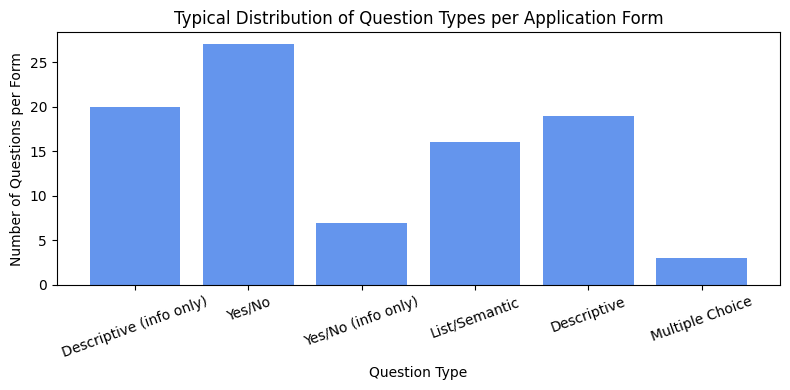

In [ ]:
from collections import Counter

# Get unique question_id → qtype mapping function as above
qid2qtype = {qid: qtype(qid) for qid in df["question_id"].unique()}

# Count how many unique qids per qtype
counts = Counter(qid2qtype.values())

# Display as a simple table
print("Typical number of questions per form (by type):\n")
for t, c in counts.items():
    print(f"{t:<22} {c}")

# display as a bar plot
import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))
plt.bar(list(counts.keys()), list(counts.values()), color="cornflowerblue")
plt.ylabel("Number of Questions per Form")
plt.xlabel("Question Type")
plt.title("Typical Distribution of Question Types per Application Form")
plt.xticks(rotation=20)
plt.tight_layout()
plt.show()


Label counts in 'compliance' column:
compliance
Compliant           4478
Fail                 305
More-information     148
Non-Compliant        133
Name: count, dtype: int64


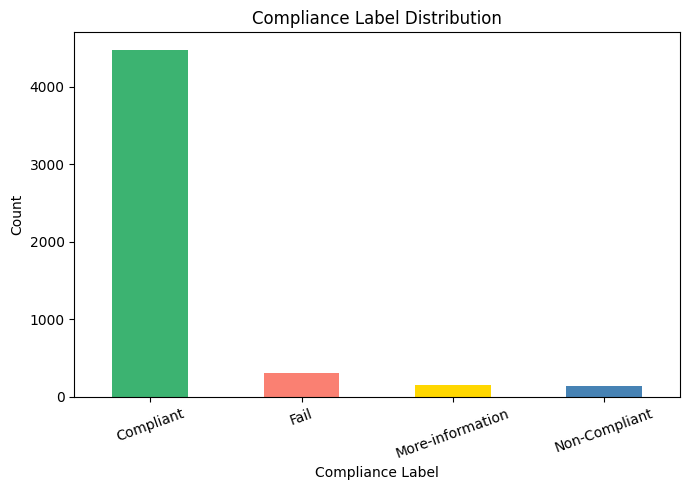

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Reload your current file (make sure it's saved!)
CSV_PATH = "/content/drive/MyDrive/project/CB/manual_annotated_questions.csv"
df = pd.read_csv(CSV_PATH, dtype=str).fillna("")

# Get value counts
label_counts = df["compliance"].value_counts(dropna=False)

# Print counts for reference
print("\nLabel counts in 'compliance' column:")
print(label_counts)

# Plot bar chart
plt.figure(figsize=(7, 5))
label_counts.plot(kind='bar', color=["mediumseagreen", "salmon", "gold", "steelblue"])
plt.title("Compliance Label Distribution")
plt.xlabel("Compliance Label")
plt.ylabel("Count")
plt.xticks(rotation=20)
plt.tight_layout()
plt.show()


### Summarisation of Application forms


Application Form Status Counts:
 FormStatus
Contains Fail                   37
Has Non-Compliant               22
Has Single More-info             4
2+ More-info (Count as Fail)     2
Name: count, dtype: int64


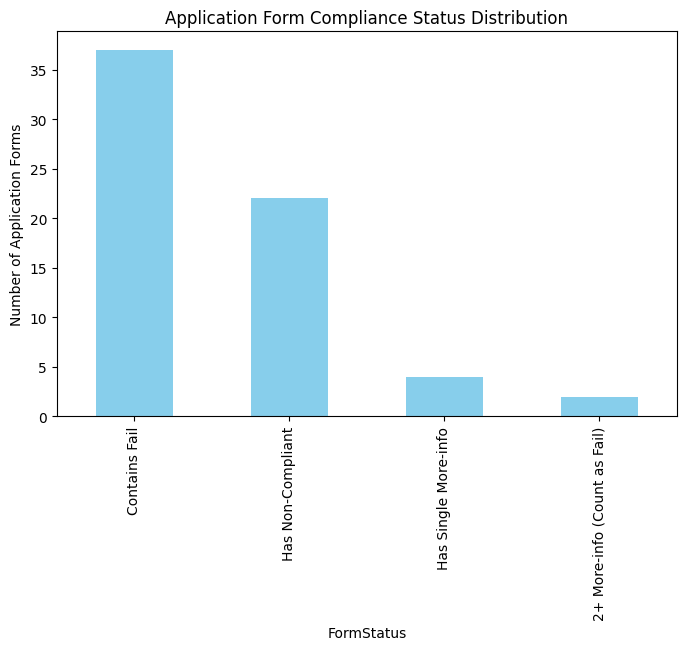

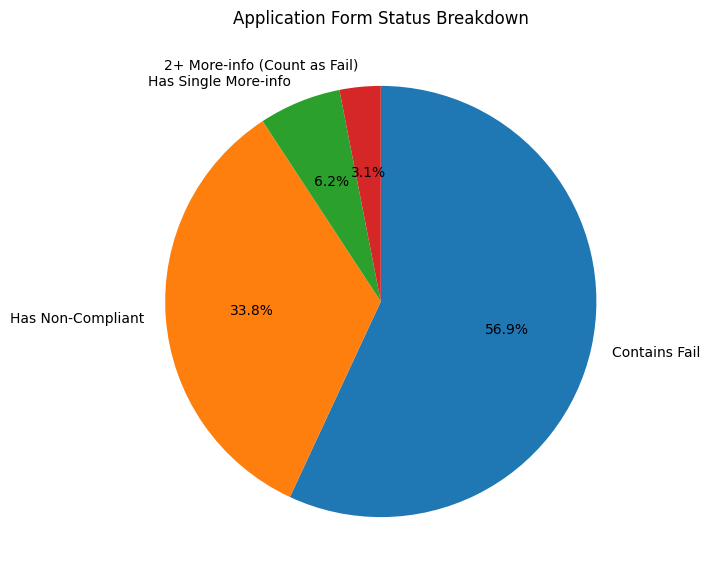

✅ Saved 0 files for 'All Compliant' to all_compliant_files.txt
✅ Saved 37 files for 'Contains Fail' to fail_files.txt
✅ Saved 22 files for 'Has Non-Compliant' to non_compliant_files.txt
✅ Saved 2 files for '2+ More-info (Count as Fail)' to two_moreinfo_files.txt
✅ Saved 4 files for 'Has Single More-info' to single_moreinfo_files.txt

All Compliant (sample):
[]

Contains Fail (sample):
['answers (1).pdf', 'answers (13).pdf', 'answers (14).pdf', 'answers (15).pdf', 'answers (16).pdf']

Has Non-Compliant (sample):
['answers (10).pdf', 'answers (11).pdf', 'answers (12).pdf', 'answers (19).pdf', 'answers (2).pdf']

2+ More-info (Count as Fail) (sample):
['answers (54).pdf', 'answers (57).pdf']

Has Single More-info (sample):
['answers (36).pdf', 'answers (45).pdf', 'answers (61).pdf', 'answers (8).pdf']


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the manually annotated questions
CSV_PATH = "/content/drive/MyDrive/project/CB/manual_annotated_questions.csv"
df = pd.read_csv(CSV_PATH, dtype=str).fillna("")

# Group by 'file' and count labels
summary = (
    df.groupby('file')['compliance']
    .value_counts()
    .unstack(fill_value=0)
    .reset_index()
)
for c in ['Compliant', 'Fail', 'Non-Compliant', 'More-information']:
    if c not in summary.columns:
        summary[c] = 0

def get_form_type(row):
    if row['Compliant'] > 0 and row['Fail'] == 0 and row['Non-Compliant'] == 0 and row['More-information'] == 0:
        return "All Compliant"
    elif row['Fail'] > 0:
        return "Contains Fail"
    elif row['Non-Compliant'] > 0 and row['Fail'] == 0:
        return "Has Non-Compliant"
    elif row['More-information'] == 1 and row['Fail'] == 0 and row['Non-Compliant'] == 0:
        return "Has Single More-info"
    elif row['More-information'] >= 2 and row['Fail'] == 0 and row['Non-Compliant'] == 0:
        return "2+ More-info (Count as Fail)"
    else:
        return "Other"

summary['FormStatus'] = summary.apply(get_form_type, axis=1)

# Display counts as a bar plot and pie chart
counts = summary['FormStatus'].value_counts()
print("\nApplication Form Status Counts:\n", counts)

plt.figure(figsize=(8,5))
counts.plot.bar(color='skyblue')
plt.ylabel("Number of Application Forms")
plt.title("Application Form Compliance Status Distribution")
plt.show()

# Pie chart (optional)
plt.figure(figsize=(7,7))
counts.plot.pie(autopct='%1.1f%%', startangle=90, counterclock=False)
plt.ylabel("")
plt.title("Application Form Status Breakdown")
plt.show()

# Save file lists
base = "/content/drive/MyDrive/project/CB/"
types = [
    ("all_compliant_files.txt", "All Compliant"),
    ("fail_files.txt", "Contains Fail"),
    ("non_compliant_files.txt", "Has Non-Compliant"),
    ("two_moreinfo_files.txt", "2+ More-info (Count as Fail)"),
    ("single_moreinfo_files.txt", "Has Single More-info")
]
for fname, formtype in types:
    flist = summary.loc[summary.FormStatus == formtype, "file"]
    with open(base+fname, "w") as f:
        for fn in flist:
            f.write(fn + "\n")
    print(f"✅ Saved {len(flist)} files for '{formtype}' to {fname}")

# Optionally print the first few files in each category:
for fname, formtype in types:
    print(f"\n{formtype} (sample):")
    flist = summary.loc[summary.FormStatus == formtype, "file"].tolist()
    print(flist[:5])


Most application forms (77%) are not fully compliant, as they contain at least one “Fail” response,indicating unmet essential requirements or missing answers. Additionally, 15% of forms have at least one “Non-Compliant” answer, reflecting serious issues that don’t qualify as outright fails. Only a small number of forms fall into the “More-information” category, showing that ambiguous or incomplete answers are relatively rare. Notably, no single form is fully compliant, highlighting  generally poor application quality as most have blank answers.

### How many forms with atleast single blank answer

In [ ]:
import pandas as pd

# Load the data
df = pd.read_csv("/content/drive/MyDrive/project/CB/manual_annotated_questions.csv", dtype=str).fillna("")

# Files with no blank answer_text
files_no_blank = (
    df.groupby("file")["answer_text"]
    .apply(lambda answers: all(answers.str.strip() != ""))  # True if all answers are non-blank
)

# Filter to only those files
files_no_blank = files_no_blank[files_no_blank].index.tolist()

print(f"Total files with no blank answers: {len(files_no_blank)}")
print("Sample files:", files_no_blank[:10])


Total files with no blank answers: 35
Sample files: ['answers (10).pdf', 'answers (11).pdf', 'answers (12).pdf', 'answers (16).pdf', 'answers (17).pdf', 'answers (19).pdf', 'answers (2).pdf', 'answers (20).pdf', 'answers (22).pdf', 'answers (25).pdf']


### Label counts for all questions of application forms

The data is very imabalanced as majority of all data are compliant.

### Explore the labels counts per question_id

In [ ]:
import pandas as pd

# Load your data
CSV_PATH = "/content/drive/MyDrive/project/CB/manual_annotated_questions.csv"
df = pd.read_csv(CSV_PATH, dtype=str).fillna("")

# Pivot table: question_id as rows, compliance labels as columns
pivot = (
    df.pivot_table(index="question_id", columns="compliance", values="file", aggfunc="count", fill_value=0)
      .reset_index()
)

# Show the first 20 rows
print(pivot.head(20))

# Save to CSV for further analysis
pivot.to_csv("/content/drive/MyDrive/project/CB/label_pivot_per_question.csv", index=False)


compliance question_id  Compliant  Fail  More-information  Non-Compliant
0                 A1.1         65     0                 0              0
1                A1.10         64     1                 0              0
2                 A1.2         65     0                 0              0
3                 A1.3         63     2                 0              0
4                 A1.4         65     0                 0              0
5                 A1.5         65     0                 0              0
6                 A1.6         65     0                 0              0
7                 A1.7         65     0                 0              0
8                 A1.8         65     0                 0              0
9               A1.8.1          6     0                 0              0
10              A1.8.2          7     0                 0              0
11              A1.8.4          2     0                 0              0
12              A1.8.5          3     0            

### - Explore the labels distributions for descriptive question_ids

In [ ]:
import pandas as pd

# --- Load your annotated data ---
CSV_PATH = "/content/drive/MyDrive/project/CB/manual_annotated_questions.csv"
df = pd.read_csv(CSV_PATH, dtype=str).fillna("")

# --- Define descriptive question IDs ---
DESC_IDS = [
    "A4.1.1","A4.10","A4.2.1","A4.6","A5.1","A5.10","A5.6",
    "A6.4.2","A6.5.2","A6.7","A7.1","A7.10","A7.11","A7.12",
    "A7.3","A7.4","A7.5","A7.6","A7.7"
]

# --- Filter for descriptive questions only ---
df_desc = df[df["question_id"].isin(DESC_IDS)]

# --- Pivot table: label distribution per question_id ---
pivot_desc = (
    df_desc.pivot_table(index="question_id",
                        columns="compliance",
                        values="file",
                        aggfunc="count",
                        fill_value=0)
           .reset_index()
)

# --- Standardize column order (Compliant, Non-Compliant) ---
for col in ["Compliant", "Non-Compliant"]:
    if col not in pivot_desc.columns:
        pivot_desc[col] = 0
pivot_desc = pivot_desc[["question_id", "Compliant", "Non-Compliant"]]

# --- Display in requested format ---
print("Label count per question_id:")
print(pivot_desc.to_string(index=True))


Label count per question_id:
compliance question_id  Compliant  Non-Compliant
0               A4.1.1         51             10
1                A4.10          8              2
2               A4.2.1         51             10
3                 A4.6         19              3
4                 A5.1         51             10
5                A5.10         55              5
6                 A5.6         13              1
7               A6.4.2         59              6
8               A6.5.2         52              9
9                 A6.7         52              0
10                A7.1         62              0
11               A7.10         53              6
12               A7.11         58              1
13               A7.12         54              5
14                A7.3         60              2
15                A7.4         56              9
16                A7.5         52              9
17                A7.6         52              9
18                A7.7         55       

**Explanations:**These data will need to be balanced as will be the one to train the LLMs.

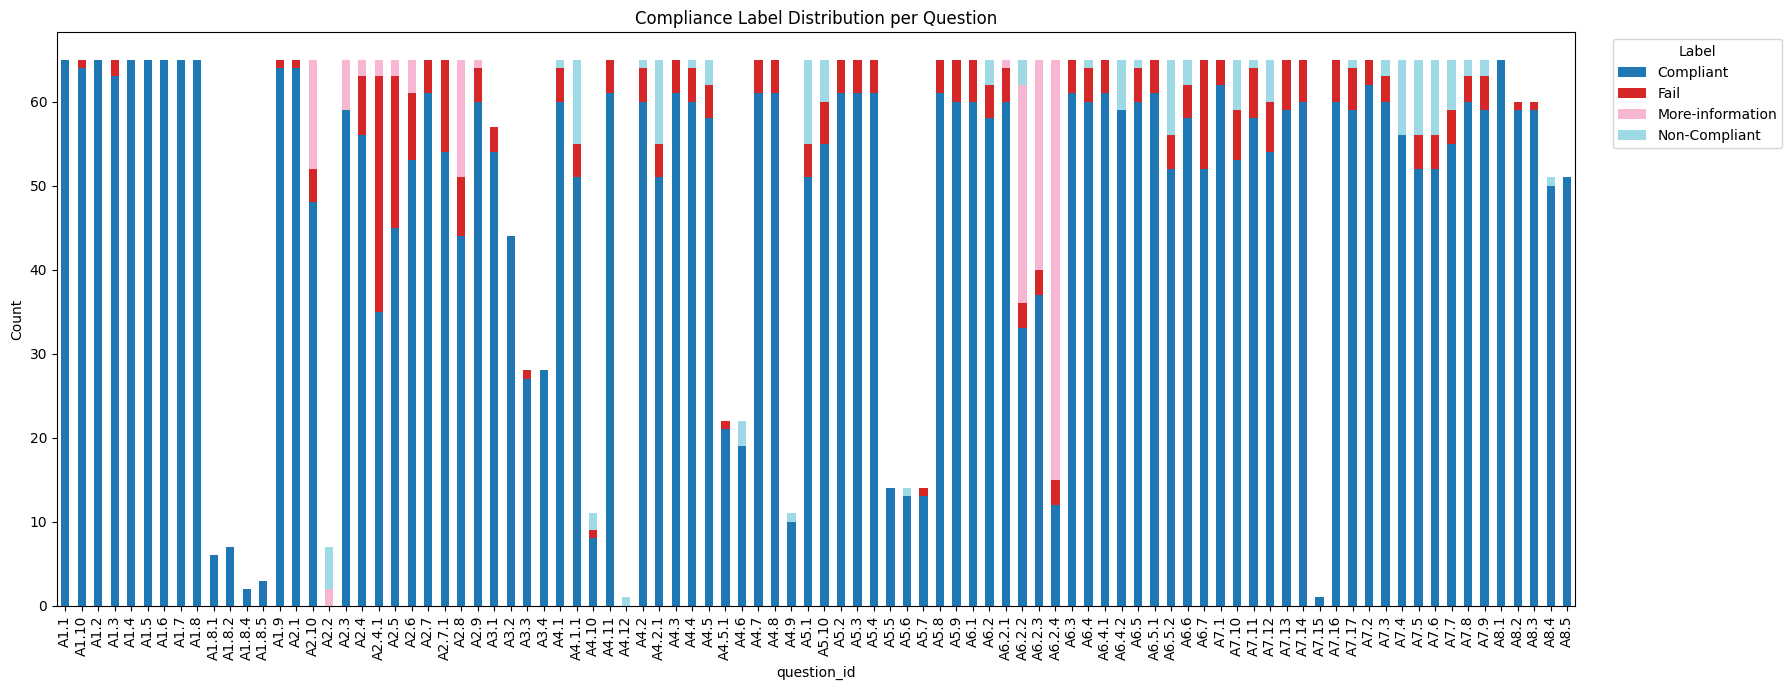

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the pivoted data
pivot = pd.read_csv("/content/drive/MyDrive/project/CB/label_pivot_per_question.csv")

# Set the question_id as index for plotting
pivot = pivot.set_index('question_id')

# Plot stacked bar
pivot.plot(
    kind='bar',
    stacked=True,
    figsize=(18, 7),
    colormap='tab20'
)
plt.ylabel("Count")
plt.title("Compliance Label Distribution per Question")
plt.legend(title='Label', bbox_to_anchor=(1.02, 1), loc='upper left')
plt.tight_layout()
plt.show()


### Heatmap: Which Questions Most Often Trigger MIR/Fail/Non-Compliant


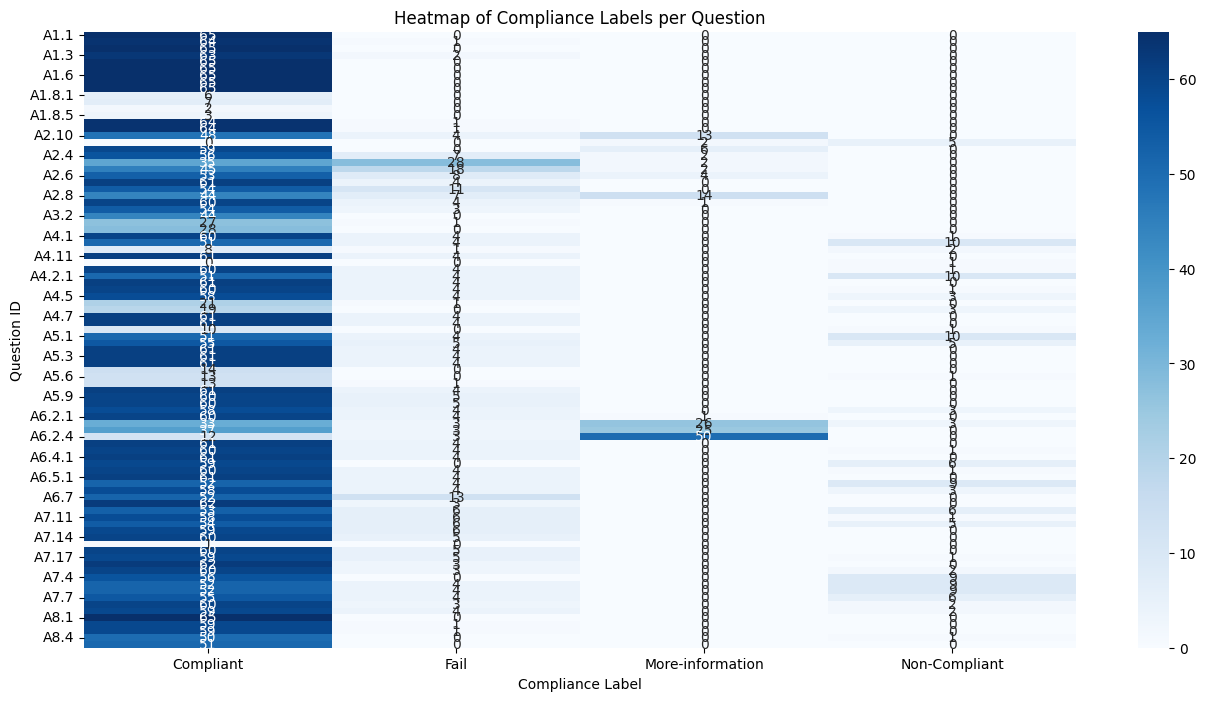

In [ ]:
import seaborn as sns

plt.figure(figsize=(16, 8))
sns.heatmap(pivot, annot=True, fmt='d', cmap='Blues')
plt.title("Heatmap of Compliance Labels per Question")
plt.ylabel("Question ID")
plt.xlabel("Compliance Label")
plt.show()


*Overall Pattern: Mostly Compliant*


The majority of applicants answered most questions in a compliant way. This is clearly shown by the strong blue coloring in the “Compliant” column of the heatmap and the dominant blue segments in the barplots. This trend is especially noticeable in the first group of questions (such as A1.1 to A1.10), which are likely designed for information-gathering rather than strict assessment. As a result, almost any answer is considered compliant, except when left blank. This pattern also indicates that most applicants remembered to fill in these informational sections. These early questions are typically simple or relate to widely implemented controls, making them easier to answer correctly.



*“Fail” and “More-Information” Hotspots*

A smaller group of questions stands out with much darker shading in the “Fail” and “More-information” columns. This indicates that many applicants either fail these questions or need to provide more detail. These problematic questions include A2.4.1, A2.5, A6.7, A6.2.4, A2.8, A2.7.1, A6.2.2, and A6.2.3. The A6.2.x questions are especially prone to generating “More-information” outcomes—likely because they ask for detailed software inventory, patching info, and version details, which applicants often skip or answer incompletely. These areas are the main pain points in the process.



*Non-Compliant Answers:*

Rare but Concerning
Although “Non-Compliant” answers are less common overall, a few specific questions show higher non-compliance rates. These include A4.2.1, A4.1.1, A5.1, A6.5.2, A7.4, A7.6, and A7.7. These questions are typically about critical security controls like multi-factor authentication, admin account rules, or patching policies. When applicants say “No” or admit to missing controls, the outcome is marked as Non-Compliant. These dark patches in the heatmap reflect real security or policy gaps in some organizations.



*Uneven Question Distribution*

Some questions show very little failure or variation, with minimal red, pink, or light blue in the charts. These are likely robust, clear, and easy-to-answer questions. In contrast, others—especially from A2.x, A6.x, and A7.x groups—have more diverse outcomes. This may be due to unclear guidance, technical complexity, or variability in organizational practices. The variation suggests that certain questions may need rewording or better examples to support applicants.




*Lower Response Counts for Some Questions*

A few bars in the plots are shorter than others, indicating that some questions were asked only in specific cases (e.g., conditional logic based on earlier answers). These shorter bars likely reflect optional sections or scoped logic.

### Heatmap by Proportionality: Which Questions Most Often Trigger MIR/Fail/Non-Compliant


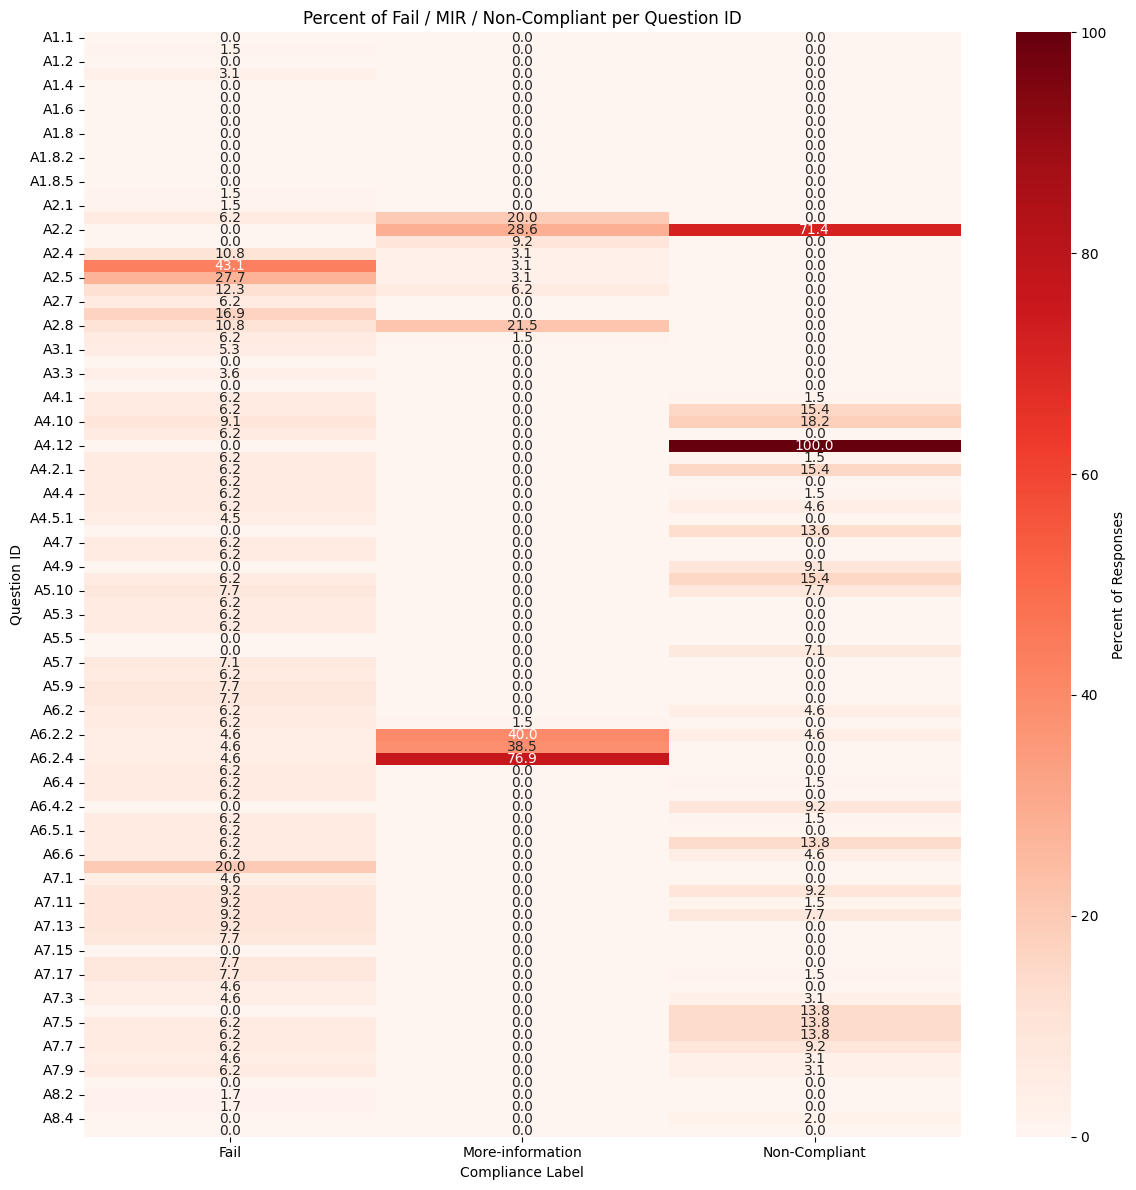

In [ ]:
import seaborn as sns

# --- Pivot by question_id ---
question_pivot = pd.pivot_table(
    df, index="question_id", columns="compliance", aggfunc="size", fill_value=0
)

# --- (Optional) Select only relevant labels for heatmap clarity ---
labels_of_interest = ["Fail", "More-information", "Non-Compliant"]
heatmap_data = question_pivot[labels_of_interest]

# --- Normalize to percent per question_id (optional) ---
heatmap_percent = heatmap_data.div(question_pivot.sum(axis=1), axis=0) * 100

# --- Plot heatmap ---
plt.figure(figsize=(12, 12))
sns.heatmap(
    heatmap_percent, annot=True, fmt=".1f", cmap="Reds",
    cbar_kws={"label": "Percent of Responses"}
)
plt.title("Percent of Fail / MIR / Non-Compliant per Question ID")
plt.ylabel("Question ID")
plt.xlabel("Compliance Label")
plt.tight_layout()
plt.show()


The heatmap reveals that most questions are “low risk,” with very pale cells indicating that nearly all responses were marked as Compliant—especially for question IDs like A1.1, A1.2, A1.6, and A5.3, which show 0% in any risk category. However, there are several high-risk questions where applicants consistently struggle. For example, A2.4.1 has a almost 41% Fail rate making it major pain points. Questions like A2.5, A2.7.1, and A6.7 also show moderate fail rates (11–17%). Questions such as A6.2.4 (~ 60% “More-information”) and A6.2.2/3 (~ 30%+) indicate widespread confusion or lack of detail. A standout issue is A4.12, which is 100% Non-Compliant—possibly due to a question logic flaw. Other questions with moderate Non-Compliant rates (under 20%) include several from sections A4, A5, A6, and A7, reflecting ongoing issues with process adherence or policy enforcement in those areas.

### Sort Questions by "Fail", "More-information", or "Non-Compliant"

In [ ]:
top_fails         = pivot.sort_values("Fail", ascending=False)[["Fail"]].head(10)
top_more_info     = pivot.sort_values("More-information", ascending=False)[["More-information"]].head(10)
top_non_compliant = pivot.sort_values("Non-Compliant", ascending=False)[["Non-Compliant"]].head(20)

print("Top 10 by Fail:\n", top_fails)
print("\nTop 10 by More-information:\n", top_more_info)
print("\nTop 10 by Non-Compliant:\n", top_non_compliant)


Top 10 by Fail:
              Fail
question_id      
A2.4.1         28
A2.5           18
A6.7           13
A2.7.1         11
A2.6            8
A2.4            7
A2.8            7
A7.12           6
A7.10           6
A7.11           6

Top 10 by More-information:
              More-information
question_id                  
A6.2.4                     50
A6.2.2                     26
A6.2.3                     25
A2.8                       14
A2.10                      13
A2.3                        6
A2.6                        4
A2.4                        2
A2.5                        2
A2.2                        2

Top 10 by Non-Compliant:
              Non-Compliant
question_id               
A4.2.1                  10
A5.1                    10
A4.1.1                  10
A6.5.2                   9
A7.6                     9
A7.4                     9
A7.5                     9
A7.7                     6
A7.10                    6
A6.4.2                   6
A2.2                     5

In [ ]:
import pandas as pd

CSV_PATH = "/content/drive/MyDrive/project/CB/manual_annotated_questions.csv"
df = pd.read_csv(CSV_PATH, dtype=str).fillna("")

# 1. Filter all rows with "Fail" label
fails = df[df["compliance"].str.strip().str.lower() == "fail"].copy()

# 2. Define what counts as 'blank/n/a' (tweak as needed)
blank_patterns = {"", "n/a", "na", "none", "not applicable", ".", "n.a."}

# Helper to check if answer_text is blank/n/a/none
def is_blank(text):
    return str(text).strip().lower() in blank_patterns

fails["is_blank"] = fails["answer_text"].apply(is_blank)

# 3. Count blank/n/a vs. not blank
n_blank = fails["is_blank"].sum()
n_nonblank = (~fails["is_blank"]).sum()

print(f"Total 'Fail' labels: {len(fails)}")
print(f"Blank/n.a./none Fail answers: {n_blank}")
print(f"Sentential Fail answers: {n_nonblank}")


Total 'Fail' labels: 305
Blank/n.a./none Fail answers: 298
Sentential Fail answers: 7


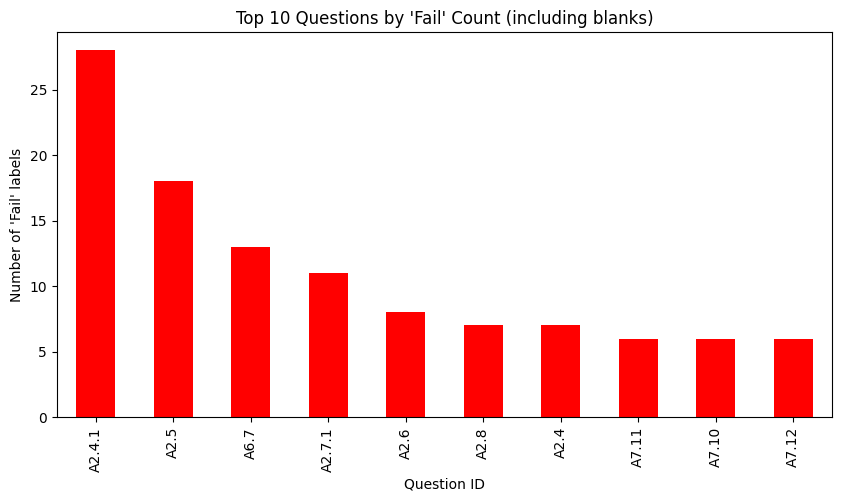

In [ ]:
# Group by question_id and count "Fail" for each question
pivot_sorted_fail = (
    df[df["compliance"].str.strip().str.lower() == "fail"]
    .groupby("question_id")
    .size()
    .sort_values(ascending=False)
    .to_frame(name="Fail")
)

# Now plot the top 10 questions by 'Fail' count
pivot_sorted_fail.head(10)["Fail"].plot.bar(
    figsize=(10, 5),
    color='red',
    title="Top 10 Questions by 'Fail' Count (including blanks)"
)
plt.ylabel("Number of 'Fail' labels")
plt.xlabel("Question ID")
plt.show()


- **Top “Fail” Questions**

The most common failures occur in the A2 section, which focuses on device and asset inventory, including questions like A2.4.1, A2.5, A2.7.1, A2.6, A2.4, and A2.8. These questions typically ask for detailed listings of hardware (servers, laptops), operating systems, device counts, and network scope. Applications fail here mostly due to blank fields, vague or incomplete asset lists, unsupported operating systems, or failure to provide specific technical details.


In [ ]:
# Filter 'Fail' rows where answer_text is NOT blank/n/a
sentential_fails = fails[~fails["is_blank"]]

# Count per question_id
sentential_fail_counts = sentential_fails["question_id"].value_counts().reset_index()
sentential_fail_counts.columns = ["question_id", "sentential_fail_count"]

print("Sentential 'Fail' answer counts per question_id:")
print(sentential_fail_counts)


Sentential 'Fail' answer counts per question_id:
  question_id  sentential_fail_count
0        A2.8                      2
1        A2.4                      2
2        A2.6                      2
3        A2.5                      1


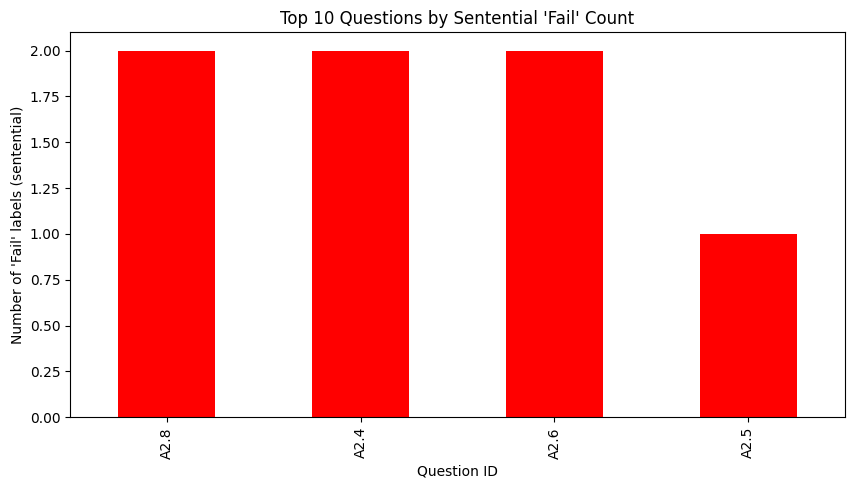

In [ ]:
# 1. Filter 'Fail' rows where answer_text is NOT blank/n/a
sentential_fails = fails[~fails["is_blank"]]

# 2. Count per question_id
sentential_fail_counts = sentential_fails["question_id"].value_counts().reset_index()
sentential_fail_counts.columns = ["question_id", "sentential_fail_count"]

# 3. Sort and plot
sentential_fail_counts_sorted = sentential_fail_counts.sort_values("sentential_fail_count", ascending=False)

sentential_fail_counts_sorted.head(10).set_index("question_id")["sentential_fail_count"].plot.bar(
    figsize=(10,5),
    color='red',
    title="Top 10 Questions by Sentential 'Fail' Count"
)
plt.ylabel("Number of 'Fail' labels (sentential)")
plt.xlabel("Question ID")
plt.show()


These obseravtions are due to :

- The items A2.4 – A2.8 belong to the “Scope of Assessment” section. Under the marking scheme, listing any unsupported endpoint or network device (e.g., Windows 7 PCs, iOS 12 phones, EoL firewalls) results in an automatic Fail, irrespective of the rest of the submission.

- Because of this zero-tolerance rule, the semantic-frame component of the pipeline must apply a strict auto-fail check for these questions: if the extracted inventory contains an OS or firmware whose vendor support has lapsed, the answer should be flagged Fail immediately, bypassing further NLP scoring.

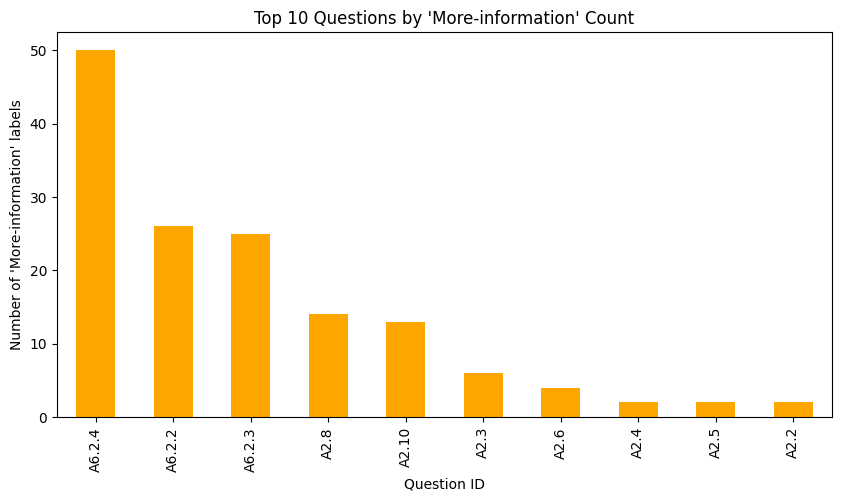

In [ ]:
top_more_info.plot.bar(
    figsize=(10,5), color='orange', legend=False,
    title="Top 10 Questions by 'More-information' Count"
)
plt.ylabel("Number of 'More-information' labels")
plt.xlabel("Question ID")
plt.show()






- **Top “More-Information” (MIR) Questions**


These questions typically ask for long-form or exhaustive lists. The A6.2.x group (e.g., A6.2.2, A6.2.3, A6.2.4) focuses on software applications, versions, and patching details, which are often difficult for applicants to address thoroughly. Similarly, A2.8, A2.10, and A2.3 request detailed enumerations of assets, software, or BYOD (Bring Your Own Device) controls. Applicants frequently receive MIRs because they submit partial answers, use ambiguous wording, or omit specific information like software versions or the scope of control.

Summary: MIRs are common when the question demands detailed or technical lists, and the applicant fails to provide full, precise, and unambiguous information.

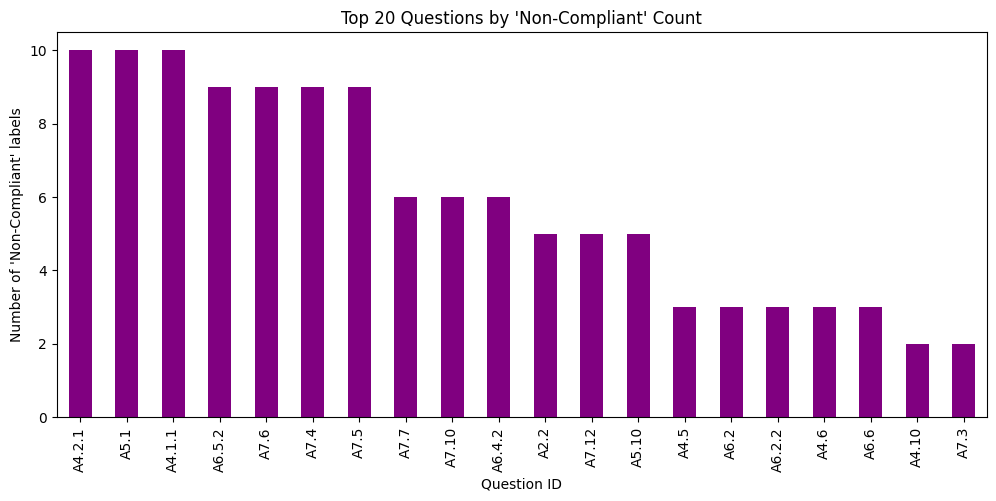

In [ ]:
top_non_compliant.plot.bar(
    figsize=(12,5), color='purple', legend=False,
    title="Top 20 Questions by 'Non-Compliant' Count"
)
plt.ylabel("Number of 'Non-Compliant' labels")
plt.xlabel("Question ID")
plt.show()








- **Top “Non-Compliant” Questions**


Non-compliance is most frequently seen in areas related to security controls and enforcement of policies. Questions like A4.2.1 and A4.1.1 relate to controls such as multi-factor authentication (MFA) and account protection. A5.1 and A5.10 cover password policies and account management, while A6.x and A7.x relate to patching processes and administrative rights. These are marked non-compliant when the applicant admits to missing controls, describes non-compliant practices, or explicitly states “No” when asked about a required control.

Summary: Non-compliant outcomes typically occur when a critical security measure is missing, not enforced, or inadequately described, revealing a clear gap in security or governance.

### **Analysis of Scoring-Descriptive and List-type questions**

- ### Average number of words per question_id

In [ ]:
import pandas as pd

# File path
CSV_PATH = "/content/drive/MyDrive/project/CB/manual_annotated_questions.csv"
df = pd.read_csv(CSV_PATH, dtype=str).fillna("")

# Sets for question IDs
semantic_ids = {
    "A2.2","A2.10","A2.3","A2.4","A2.4.1","A2.5","A2.6","A2.7","A2.7.1","A2.8","A2.9",
    "A4.12","A6.2.1","A6.2.2","A6.2.3","A6.2.4"
}
descriptive_ids = {
    "A4.1.1", "A4.10", "A4.2.1", "A4.6", "A5.1", "A5.10", "A5.6",
    "A6.4.2", "A6.5.2", "A6.7", "A7.1", "A7.10", "A7.11", "A7.12",
    "A7.3", "A7.4", "A7.5", "A7.6", "A7.7"
}
all_ids = semantic_ids | descriptive_ids

# Filter to relevant rows
filtered = df[df['question_id'].isin(all_ids)].copy()

# Function to count words
def word_count(text):
    return len(str(text).strip().split())

filtered['word_count'] = filtered['answer_text'].apply(word_count)

# Group by question_id, aggregate stats
word_stats = (
    filtered.groupby("question_id")['word_count']
    .agg(['mean', 'median', 'min', 'max', 'count'])
    .sort_values('mean', ascending=False)
)
print(word_stats.head(10))  # show sample


                  mean  median  min  max  count
question_id                                    
A7.5         57.892308    42.0    0  442     65
A7.6         56.553846    38.0    0  365     65
A4.2.1       55.584615    37.0    0  347     65
A5.6         54.428571    41.5    7  131     14
A7.7         50.430769    43.0    0  381     65
A5.1         50.384615    29.0    0  421     65
A7.4         50.338462    39.0    4  372     65
A7.3         46.538462    34.0    0  377     65
A7.1         46.169231    33.0    0  381     65
A4.6         37.909091    31.0   12   75     22


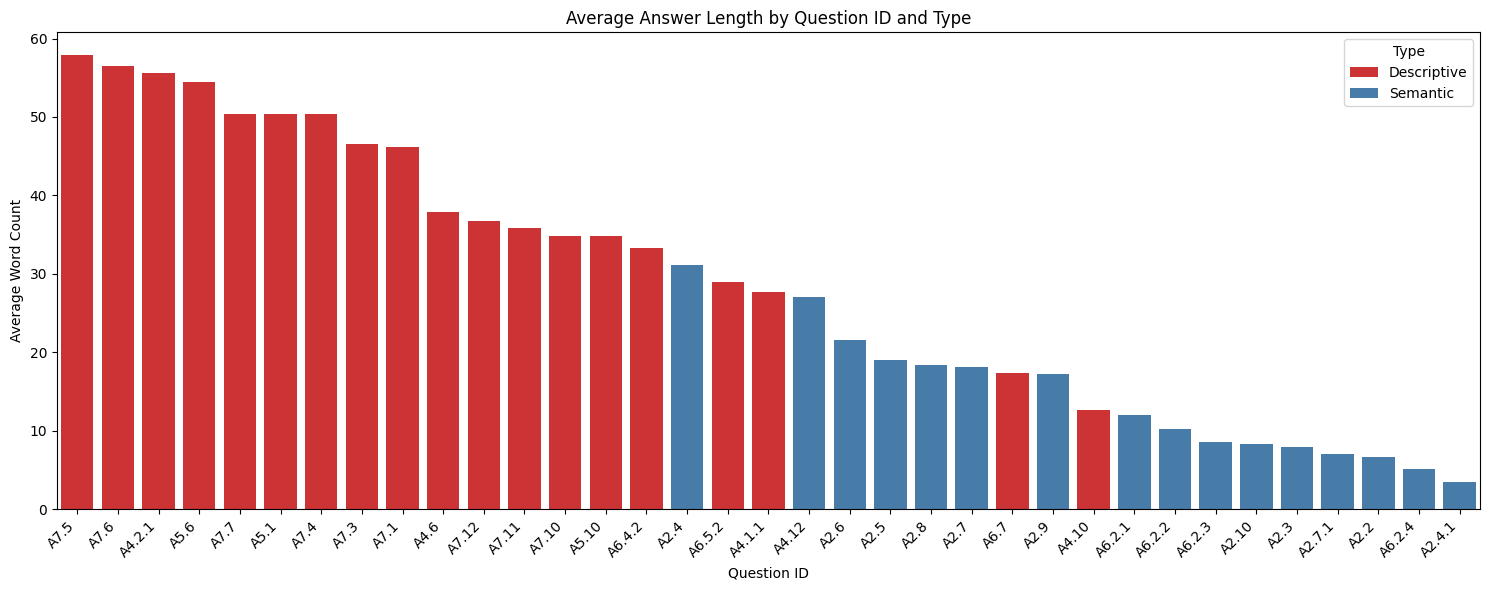

In [ ]:
def qtype(qid):
    if qid in semantic_ids:
        return "Semantic"
    elif qid in descriptive_ids:
        return "Descriptive"
    else:
        return "Other"

word_stats['type'] = word_stats.index.map(qtype)

# You can then plot by type if you wish
import seaborn as sns

plt.figure(figsize=(15, 6))
sns.barplot(
    data=word_stats.reset_index(),
    x="question_id", y="mean", hue="type", dodge=False, palette="Set1"
)
plt.title("Average Answer Length by Question ID and Type")
plt.ylabel("Average Word Count")
plt.xlabel("Question ID")
plt.xticks(rotation=45, ha='right')
plt.legend(title="Type")
plt.tight_layout()
plt.show()


The analysis of average answer lengths shows that descriptive questions consistently receive the longest responses. The top 10 question IDs by word count are all descriptive (e.g., A7.5, A4.2.1, A5.1), with averages ranging from 46 to 58 words and some responses exceeding 300–400 words. These questions typically ask applicants to describe processes or justify security controls, which leads to longer, more detailed answers. However, minimum word counts of zero reveal that some forms leave these answers blank or include only short placeholders like “N/A.” The distributions are skewed (mean greater than median), suggesting a few applicants write excessively long answers, possibly pasting in policy documents. These descriptive questions are high-effort both to complete and to assess, often becoming subjective judgment points. In contrast, semantic or list-type questions tend to produce shorter, more uniform answers, usually consisting of names or simple factual inputs. Overall, the length of answers reflects the complexity and effort required, with implications for both applicant clarity and assessor workload.

### - Distribution of words lengths across labels for both semantic and Descriptive questions

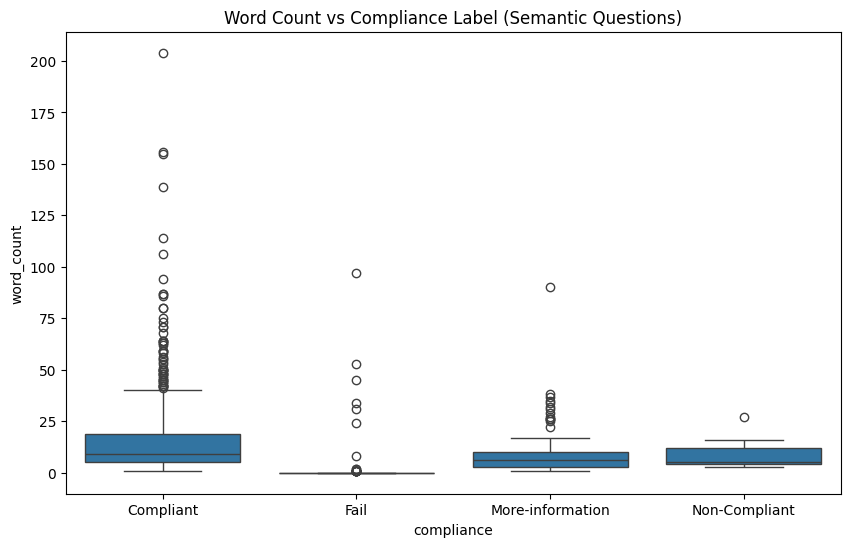

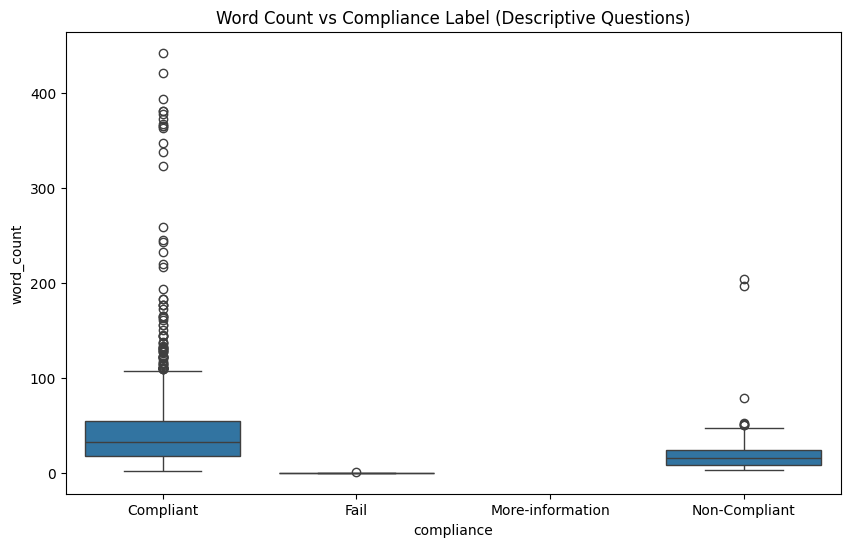

Semantic questions, word count by label:
                  count       mean        std  min  25%  50%   75%    max
compliance                                                               
Compliant         657.0  16.211568  19.990455  1.0  5.0  9.0  19.0  204.0
Fail              104.0   2.932692  12.511171  0.0  0.0  0.0   0.0   97.0
More-information  148.0   8.601351  10.351470  1.0  3.0  6.0  10.0   90.0
Non-Compliant       9.0   9.222222   7.933753  3.0  4.0  5.0  12.0   27.0

Descriptive questions, word count by label:
               count       mean        std  min   25%   50%   75%    max
compliance                                                              
Compliant      913.0  46.654984  55.159461  2.0  18.0  32.0  54.0  442.0
Fail            71.0   0.014085   0.118678  0.0   0.0   0.0   0.0    1.0
Non-Compliant  103.0  21.864078  28.859718  3.0   8.0  15.0  24.0  204.0


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load data
CSV_PATH = "/content/drive/MyDrive/project/CB/manual_annotated_questions.csv"
df = pd.read_csv(CSV_PATH, dtype=str).fillna("")

# Define your ID sets
semantic_ids = {
    "A2.2","A2.10","A2.3","A2.4","A2.4.1","A2.5","A2.6","A2.7","A2.7.1","A2.8","A2.9",
    "A4.12","A6.2.1","A6.2.2","A6.2.3","A6.2.4"
}
descriptive_ids = {
    "A4.1.1", "A4.10", "A4.2.1", "A4.6", "A5.1", "A5.10", "A5.6",
    "A6.4.2", "A6.5.2", "A6.7", "A7.1", "A7.10", "A7.11", "A7.12",
    "A7.3", "A7.4", "A7.5", "A7.6", "A7.7"
}

# Add word count column
df['word_count'] = df['answer_text'].apply(lambda x: len(str(x).split()))

# Subset for each type
df_semantic = df[df['question_id'].isin(semantic_ids)]
df_desc = df[df['question_id'].isin(descriptive_ids)]

# Plot for Semantic IDs
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_semantic, x='compliance', y='word_count', order=['Compliant', 'Fail', 'More-information', 'Non-Compliant'])
plt.title('Word Count vs Compliance Label (Semantic Questions)')
plt.show()

# Plot for Descriptive IDs
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_desc, x='compliance', y='word_count', order=['Compliant', 'Fail', 'More-information', 'Non-Compliant'])
plt.title('Word Count vs Compliance Label (Descriptive Questions)')
plt.show()

# Optionally: Print stats per label
print("Semantic questions, word count by label:")
print(df_semantic.groupby("compliance")["word_count"].describe())
print("\nDescriptive questions, word count by label:")
print(df_desc.groupby("compliance")["word_count"].describe())


Semantic-list answers

---
Semantic-list answers show substantial overlap in word
count between Compliant and Non-Compliant labels, with both typically falling within a 4–15 word range. This means length alone doesn’t distinguish them well. Fail responses, however, cluster around 0–2 words, indicating they are mostly blank or token replies. Notably, Compliant outliers can be very long (often detailed device lists), while Non-Compliant answers rarely exceed 30 words. All categories except Fail are right-skewed, showing occasional long answers. In short, answer length is a reliable signal for identifying Fail responses, but not enough to differentiate Compliant from Non-Compliant—more nuanced content features are needed for that.

Descriptive-answers

---

In descriptive (narrative) responses, answer length is a strong indicator of quality. Fail answers are nearly all blank or one-word entries. Compliant responses are significantly longer than Non-Compliant ones, often twice as long, and only Compliant answers contain very lengthy outliers (over 100 words). This suggests that assessors value detailed explanations but penalize vague or incomplete ones rather than length alone. All non-Fail groups are right-skewed, especially Compliant, showing that elaboration is encouraged but not required. Practically, a length of ~30 words often signals compliance, while answers under 10 words may need further review or be flagged as needing more information.

- ### Correlation Analysis

In [ ]:
# Make an explicit copy to avoid SettingWithCopyWarning
df_desc = df[df['question_id'].isin(descriptive_ids)].copy()

# For descriptive questions, make compliance binary (1=Compliant, 0=other)
df_desc['is_compliant'] = (df_desc['compliance'] == "Compliant").astype(int)

corr = df_desc[['word_count', 'is_compliant']].corr(method='spearman')
print("Spearman correlation between word count and Compliant (Descriptive):\n", corr)


Spearman correlation between word count and Compliant (Descriptive):
               word_count  is_compliant
word_count       1.00000       0.43421
is_compliant     0.43421       1.00000


- ### Regression/Trendline

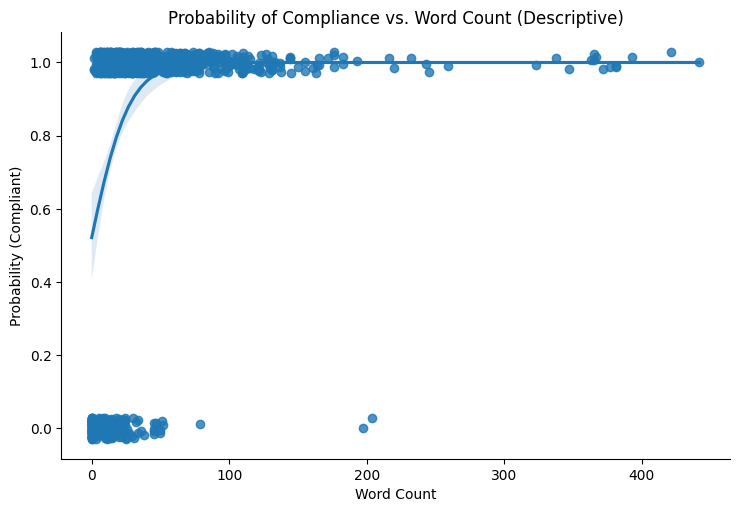

In [ ]:
sns.lmplot(
    x='word_count', y='is_compliant', data=df_desc,
    logistic=True, y_jitter=.03, height=5, aspect=1.5
)
plt.title("Probability of Compliance vs. Word Count (Descriptive)")
plt.xlabel("Word Count")
plt.ylabel("Probability (Compliant)")
plt.show()


The analysis reveals a clear relationship between answer length and compliance. Compliant answers tend to be significantly longer, with many exceeding 40–50 words and some going beyond 100, as shown by the higher medians and quartiles in the boxplot. In contrast, “Fail” answers are mostly very short—often under 10 words—likely due to blanks or minimal entries like “n/a.” “Non-Compliant” answers are generally short as well but slightly longer than “Fail,” while “More-information” responses fall somewhere in between.


A scatter plot of compliance probability versus word count shows a steep upward trend: short answers (<20 words) are rarely compliant, but as length increases past 30–40 words, the likelihood of compliance rises rapidly, reaching over 80% and nearing certainty at 60–80 words. The relationship follows a non-linear curve, with a sharp rise followed by a plateau.


Statistically, a Spearman’s rho of 0.43421 indicates a moderate positive correlation—longer answers are more likely to be compliant, though exceptions exist.

### **Lexical & Linguistic Patterns**

### - Top Bigrams/Trigrams

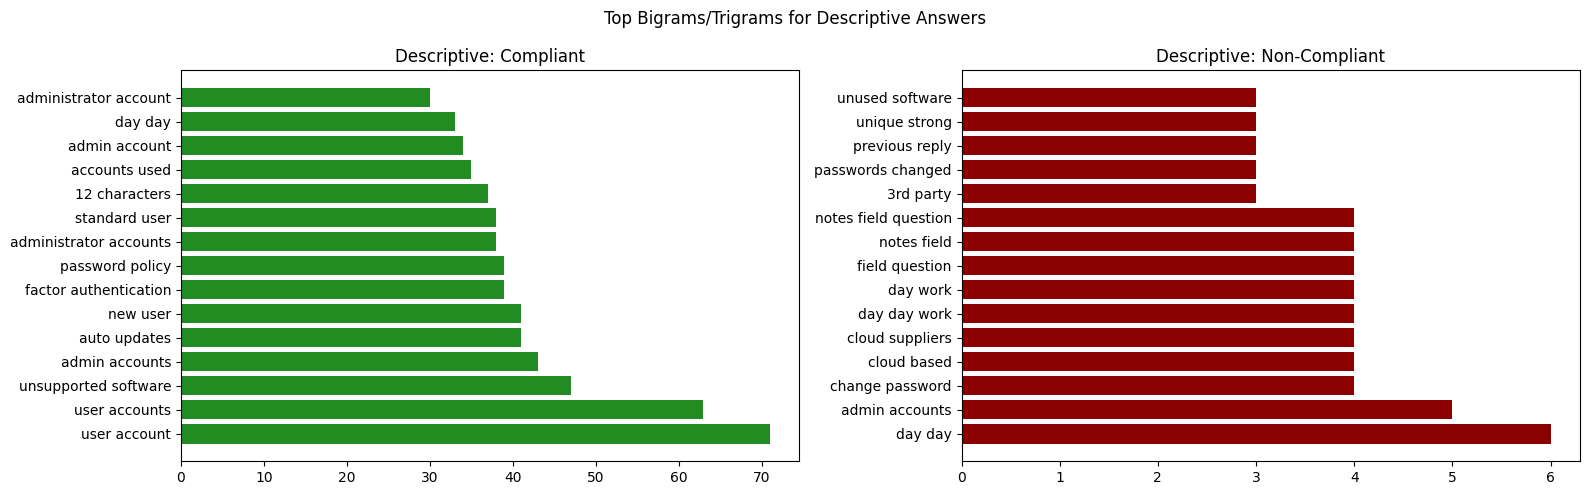

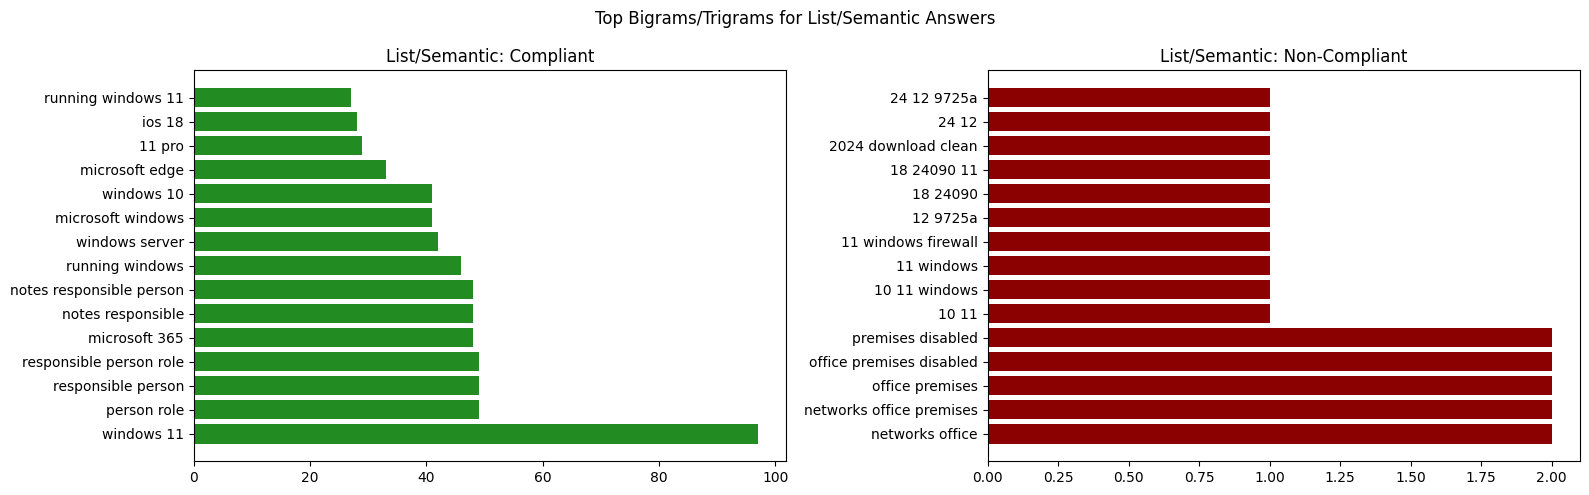

In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt

CSV_PATH = "/content/drive/MyDrive/project/CB/manual_annotated_questions.csv"
df = pd.read_csv(CSV_PATH, dtype=str).fillna("")

# IDs
descriptive_ids = {
    "A4.1.1", "A4.10", "A4.2.1", "A4.6", "A5.1", "A5.10", "A5.6",
    "A6.4.2", "A6.5.2", "A6.7", "A7.1", "A7.10", "A7.11", "A7.12",
    "A7.3", "A7.4", "A7.5", "A7.6", "A7.7"
}
semantic_ids = {
    "A2.2", "A2.10", "A2.3", "A2.4", "A2.4.1", "A2.5", "A2.6", "A2.7", "A2.7.1", "A2.8", "A2.9",
    "A4.12", "A6.2.1", "A6.2.2", "A6.2.3", "A6.2.4"
}

# Filter relevant rows
desc_sem_df = df[df['question_id'].isin(descriptive_ids | semantic_ids)].copy()
desc_sem_df['qtype'] = desc_sem_df['question_id'].map(
    lambda qid: "Descriptive" if qid in descriptive_ids else "List/Semantic"
)

for qtype in ["Descriptive", "List/Semantic"]:
    fig, axes = plt.subplots(1, 2, figsize=(16, 5))
    for i, label in enumerate(["Compliant", "Non-Compliant"]):
        mask = (desc_sem_df['qtype'] == qtype) & (desc_sem_df['compliance'] == label)
        texts = desc_sem_df.loc[mask, 'answer_text'].dropna().tolist()
        if not texts:
            axes[i].set_title(f"{qtype}: {label} (No Data)")
            axes[i].axis("off")
            continue
        vect = CountVectorizer(ngram_range=(2, 3), stop_words='english', min_df=1, max_features=15)
        X = vect.fit_transform(texts)
        if X.shape[1] == 0:
            axes[i].set_title(f"{qtype}: {label} (No ngrams found)")
            axes[i].axis("off")
            continue
        ngram_freq = dict(zip(vect.get_feature_names_out(), X.sum(axis=0).A1))
        ngram_items = sorted(ngram_freq.items(), key=lambda x: -x[1])
        axes[i].barh(
            [k for k, v in ngram_items],
            [v for k, v in ngram_items],
            color="forestgreen" if label == "Compliant" else "darkred"
        )
        axes[i].set_title(f"{qtype}: {label}")
    plt.suptitle(f"Top Bigrams/Trigrams for {qtype} Answers")
    plt.tight_layout()
    plt.show()


**1st Takeaway:**

---



 - The better answers use proper security terms. Vague or confusing answers are more likely to be non-compliant.

When people write good (compliant) descriptive answers, they often use clear and specific phrases like “user account,” “password policy,” or “admin accounts.” These show they understand what the question is asking.

In bad (non-compliant) answers, we see vague or odd phrases like “day day” or “field question,” which might mean someone copied text or didn’t understand the question.



**2nd Takeaway:**

---



 - Listing exact tools or people helps. Jumbled or vague lists hurt the score.

In compliant list answers, people often name specific software or roles like “Windows 11,” “Microsoft 365,” or “responsible person.” This is helpful and shows they know what they’re talking about.

Non-compliant answers include strange or messy phrases like “18 24090 11” or “office premises disabled,” which could be typos or unclear references.



#### - Vague Language Detection (Heatmap by question_id & Label)

/tmp/ipython-input-2274687680.py:7: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  desc_sem_df['vague_flag'] = desc_sem_df['answer_text'].str.contains(vague_terms, case=False, regex=True, na=False)


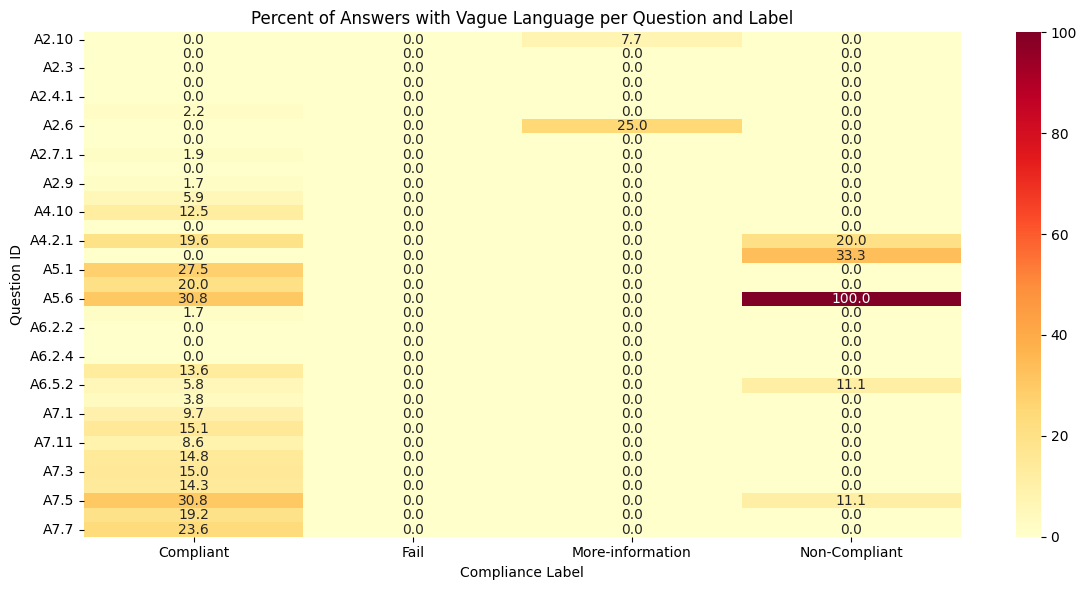

In [ ]:
import numpy as np
import seaborn as sns

# Define basic hedging terms (expand as needed)
vague_terms = r"\b(possible|generally|likely|sometimes|usually|typically|often|maybe|as needed|if necessary|where appropriate|as appropriate|in most cases|can|could|may|might|should|mainly|almost|somewhat|relatively|rarely|commonly|depends)\b"

desc_sem_df['vague_flag'] = desc_sem_df['answer_text'].str.contains(vague_terms, case=False, regex=True, na=False)

# Pivot: % of vague answers per qid and label
heat = pd.pivot_table(
    desc_sem_df, index='question_id', columns='compliance',
    values='vague_flag', aggfunc='mean', fill_value=0
)
plt.figure(figsize=(12,6))
sns.heatmap(heat*100, annot=True, fmt=".1f", cmap="YlOrRd")
plt.title("Percent of Answers with Vague Language per Question and Label")
plt.ylabel("Question ID")
plt.xlabel("Compliance Label")
plt.tight_layout(); plt.show()


Key Observations:

---



A5.6 (Non-Compliant = 100 %) – every NC answer is vague.



A4.2.1 (MIR ≈ 33 %) – a third of “More-information” answers are vague.



A5.1 & A5.6 (Compliant ≈ 28–31 %) – even some “Compliant” responses are still vague here.



A7.5 (Compliant ≈ 30 %) – admin-access question often answered vaguely.



Virtually zero vagueness in most A2 (inventory) questions.

#### - Stopword Percentage by Question Type and Label

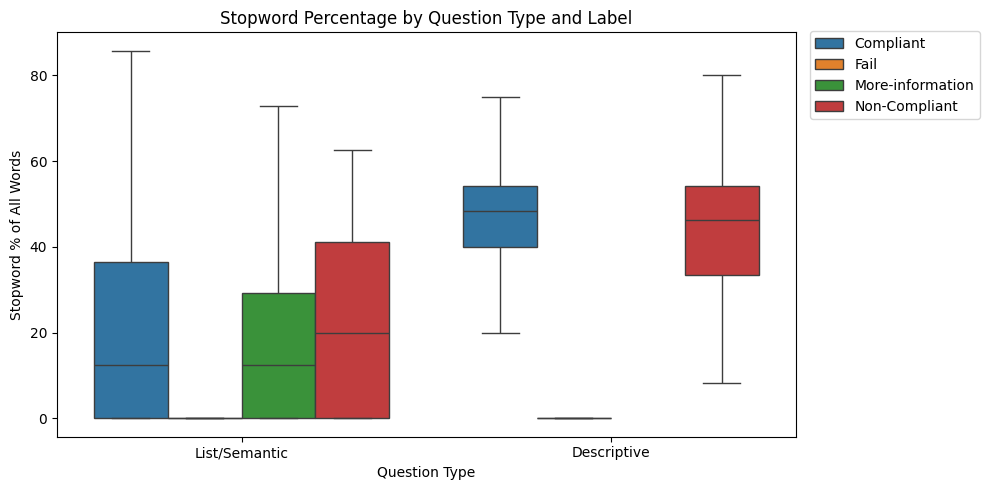

In [ ]:
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

def stopword_percent(text):
    tokens = [w for w in str(text).split() if w.isalpha()]
    if not tokens: return 0
    stopwords = [w for w in tokens if w.lower() in ENGLISH_STOP_WORDS]
    return len(stopwords)/len(tokens)*100

desc_sem_df['stopword_pct'] = desc_sem_df['answer_text'].apply(stopword_percent)

plt.figure(figsize=(10,5))
sns.boxplot(x='qtype', y='stopword_pct', hue='compliance', data=desc_sem_df, showfliers=False)
plt.title("Stopword Percentage by Question Type and Label")
plt.ylabel("Stopword % of All Words")
plt.xlabel("Question Type")
plt.legend(bbox_to_anchor=(1.01, 1.02))
plt.tight_layout(); plt.show()


The boxplot titled “Stopword Percentage by Question Type and Label” reveals clear differences in stopword usage between question types, but limited predictive power within labels. For List/Semantic questions, Compliant and More-Information answers show very low median stopword percentages (10–15%) with heavy overlap, confirming that stopword density does not distinguish these labels. Non-Compliant responses in this category have slightly higher medians (20%) and wider spread, indicating vaguer, more verbose answers, though overlap with other labels remains high. In contrast, Descriptive answers—both Compliant and Non-Compliant—exhibit much higher median stopword percentages (45–55%) due to natural sentence structure, with little separation between the labels. Overall, stopword percentage may help flag vague or poorly structured List responses, but it is not a reliable indicator for Descriptive answers or for separating More-Information from Compliant cases.


### - Keyword and Bigram Frequency Analysis in Device and Asset Listing Questions

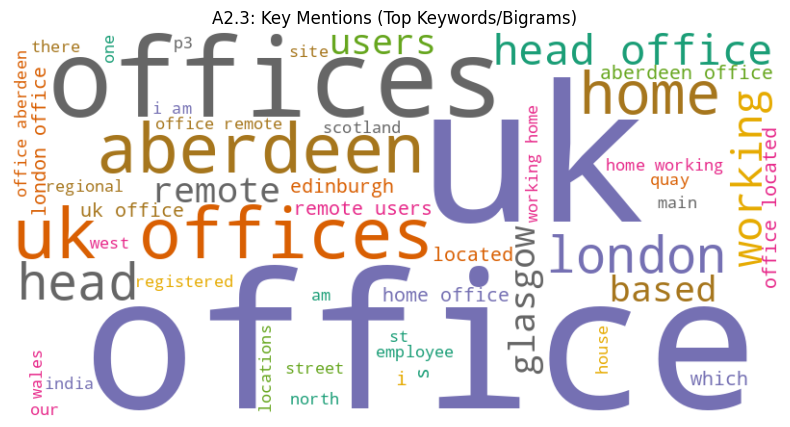

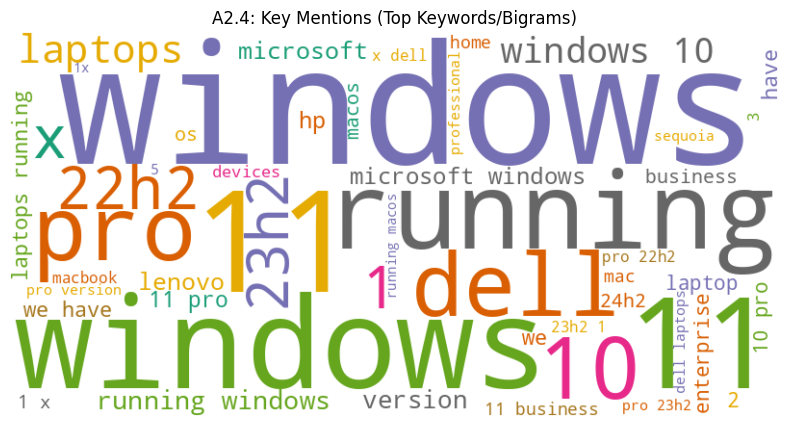

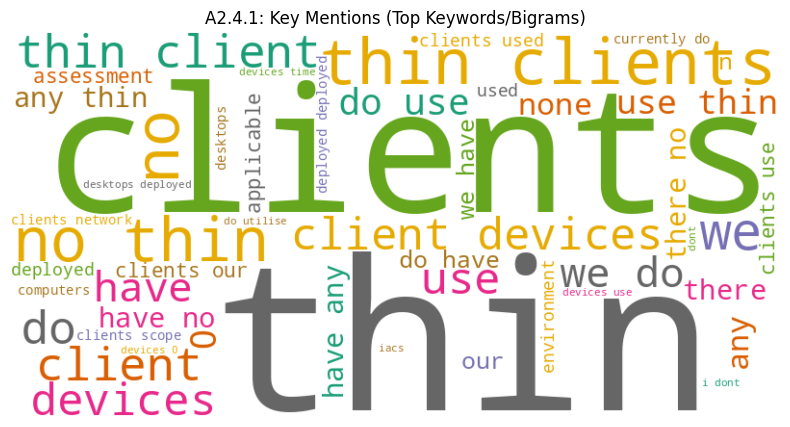

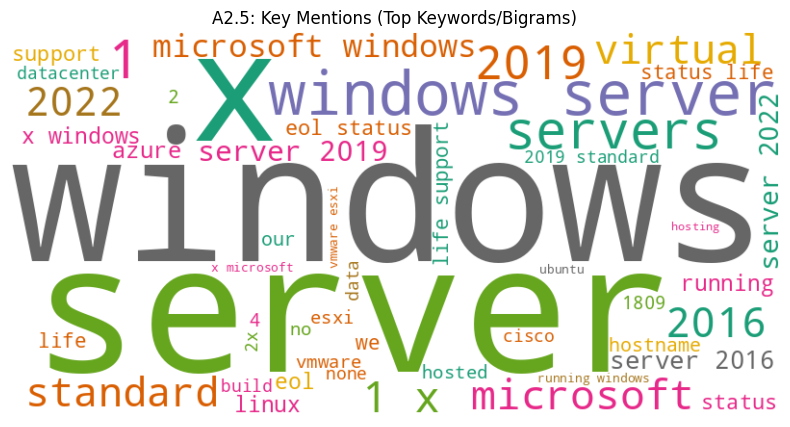

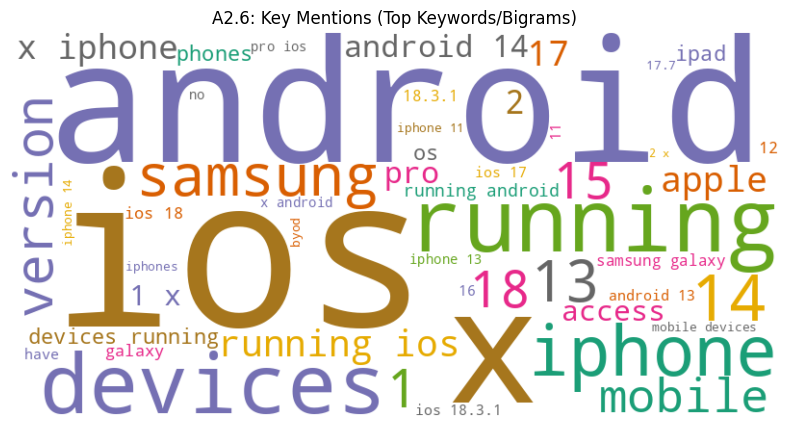

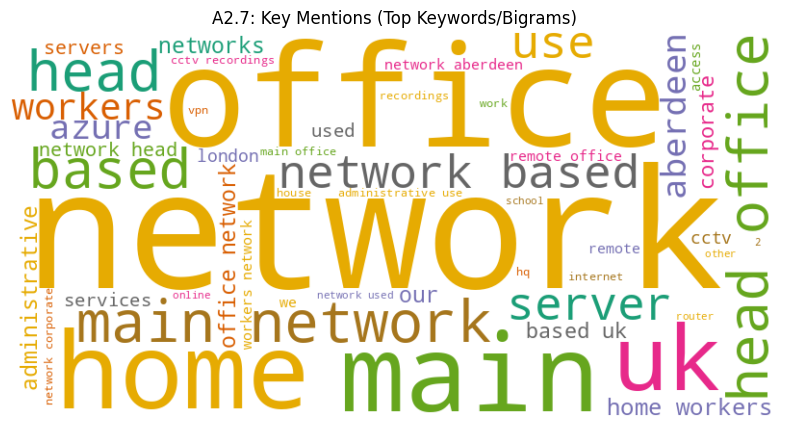

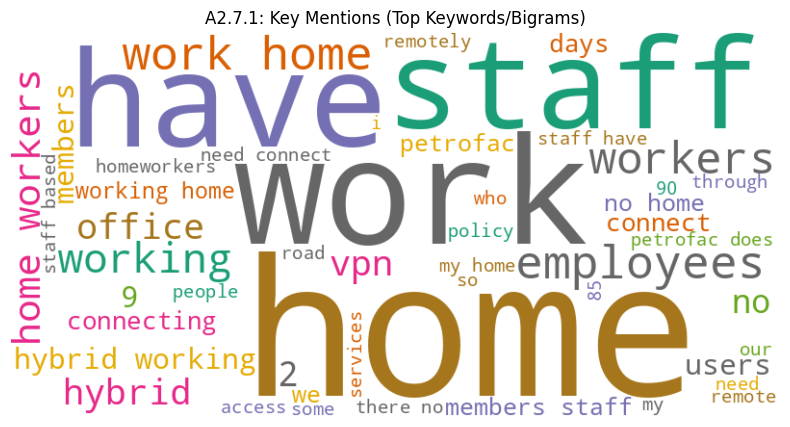

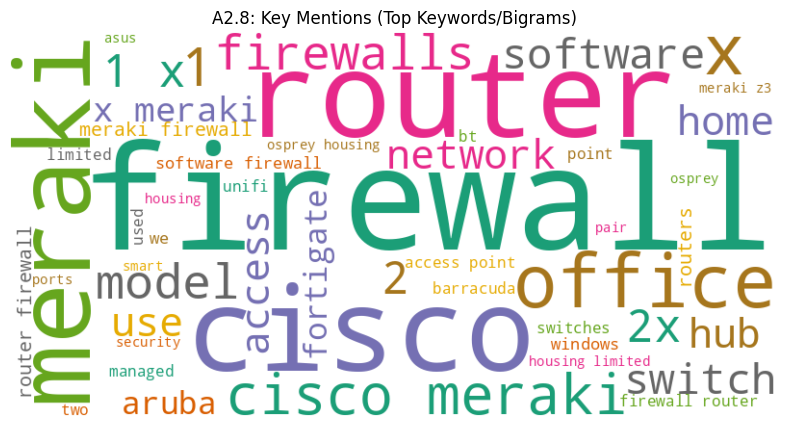

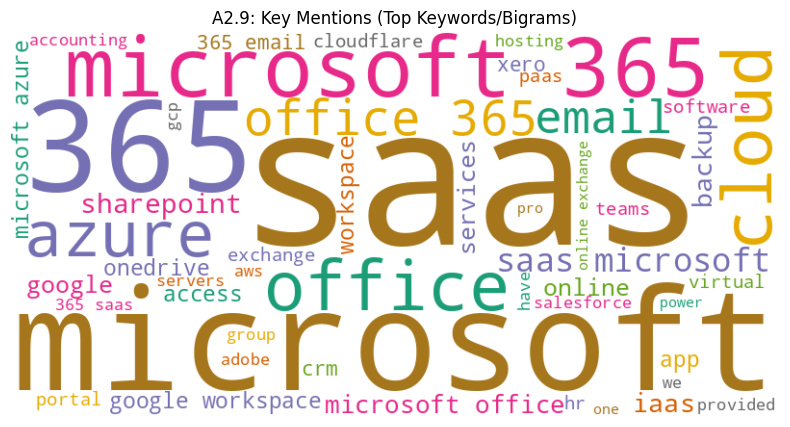

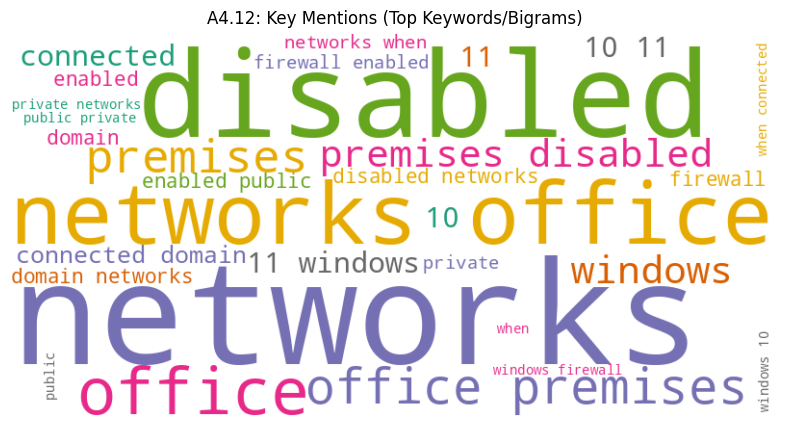

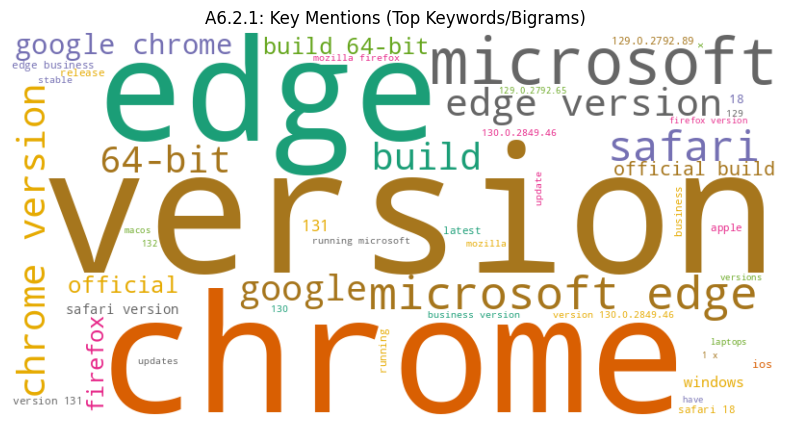

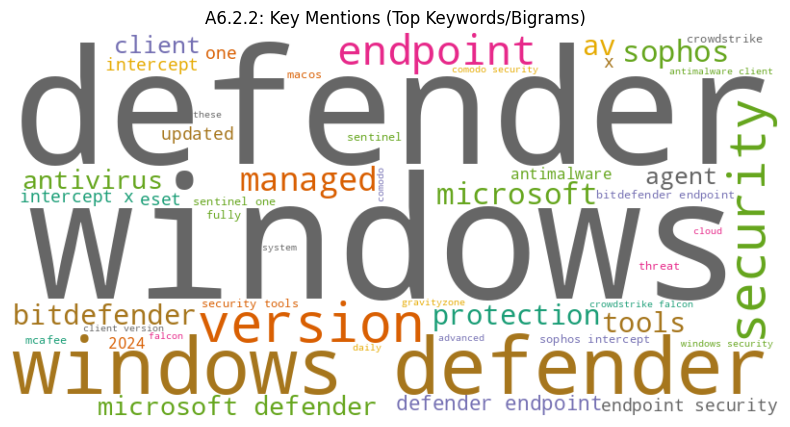

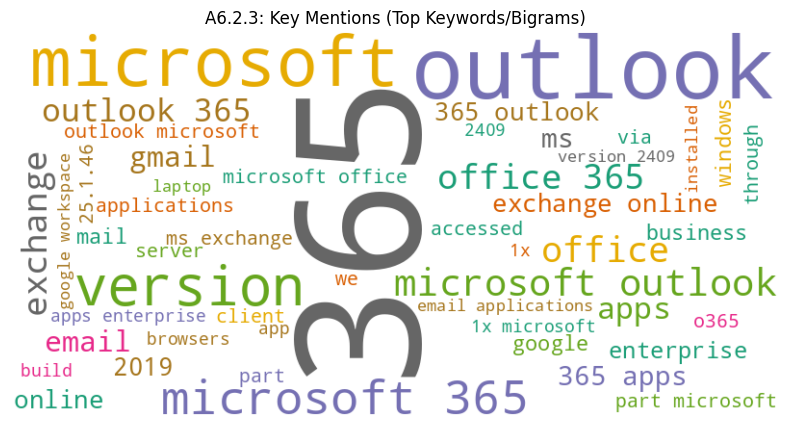

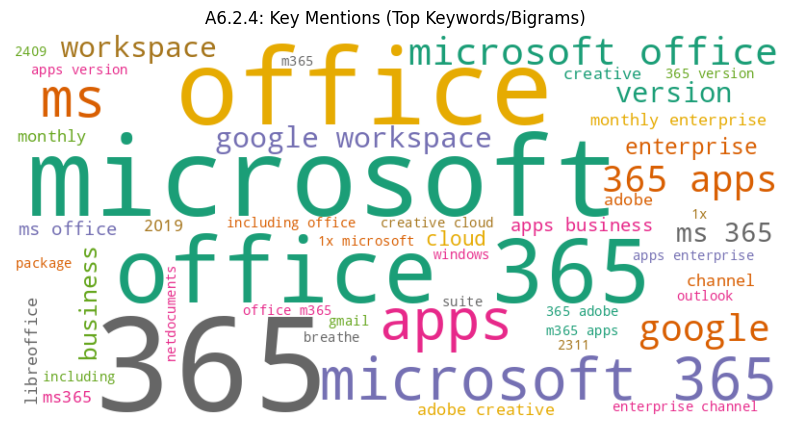

In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# === Load your annotated dataset ===
CSV_PATH = "/content/drive/MyDrive/project/CB/manual_annotated_questions.csv"
df = pd.read_csv(CSV_PATH, dtype=str).fillna("")

# === Semantic question IDs to analyze ===
semantic_ids = [
    "A2.3", "A2.4", "A2.4.1", "A2.5", "A2.6", "A2.7", "A2.7.1",
    "A2.8", "A2.9", "A4.12", "A6.2.1", "A6.2.2", "A6.2.3", "A6.2.4"
]

# === Custom stopwords (expand if needed) ===
custom_stopwords = [
    "the", "and", "of", "to", "a", "in", "for", "with", "on", "by", "is", "at", "as", "or", "it", "from",
    "all", "not", "only", "be", "that", "are", "an", "this", "must", "should", "include", "within"
]

# === Loop through each semantic question ID ===
for qid in semantic_ids:
    # Filter for answers to this question
    texts = df[df['question_id'] == qid]['answer_text'].dropna().tolist()

    if not texts:
        continue  # Skip if no data

    # Set up CountVectorizer to extract unigrams and bigrams
    vect = CountVectorizer(
        ngram_range=(1, 2),
        stop_words=custom_stopwords,
        max_features=50,
        token_pattern=r'(?u)\b[a-zA-Z0-9._+-]+\b'
    )

    # Vectorize the text
    X = vect.fit_transform(texts)
    freqs = dict(zip(vect.get_feature_names_out(), X.sum(axis=0).A1))

    if not freqs:
        continue  # Skip if no valid terms

    # === Generate and show word cloud ===
    wc = WordCloud(
        width=800,
        height=400,
        background_color="white",
        colormap="Dark2"
    ).generate_from_frequencies(freqs)

    plt.figure(figsize=(10, 5))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    plt.title(f"{qid}: Key Mentions (Top Keywords/Bigrams)")
    plt.show()


Most forms (A2.3) mention traditional devices like laptops, desktops, and servers, while tablets and virtual machines are rarely included. Windows 11 and 10 are the main operating systems in A2.4, with Windows 11 now leading, and macOS also present. In A2.4.1, thin clients are rarely used, and older or unsupported systems like Windows 7 appear very little. A2.5 shows that modern server OSs like Windows Server 2022, Ubuntu 22.04, and AWS EC2 are common, though some older on-prem servers still show up. For mobile devices (A2.6), iOS and Android are both popular, with newer versions dominating.


 A2.7 highlights the use of tools like Intune, JAMF, and WSUS for firmware updates and OS configuration, while manual updates often flag issues. In A2.7.1, most forms clearly name a responsible party like IT Manager or MSP. A2.8 shows that security settings often use Intune Baseline, Group Policy, or JAMF Pro, and A2.9 confirms that auto-updates are the norm. A4.12 reveals that firewall rules like “disabled on domain” are common but sometimes contradict other answers.


  A6.2.1 indicates most applicants use MFA or 2FA, A6.2.2 confirms that default passwords are changed, and A6.2.3 shows that strong password policies (12+ characters and complexity) are widely applied. Finally, A6.2.4 reports that Microsoft 365 is the most commonly licensed app, followed by Google Workspace.

### - Distributional Analysis of Descriptive Questions


Label distribution for each descriptive question ID:
compliance   Compliant  Fail  Non-Compliant
question_id                                
A4.1.1              51     4             10
A4.10                8     1              2
A4.2.1              51     4             10
A4.6                19     0              3
A5.1                51     4             10
A5.10               55     5              5
A5.6                13     0              1
A6.4.2              59     0              6
A6.5.2              52     4              9
A6.7                52    13              0
A7.1                62     3              0
A7.10               53     6              6
A7.11               58     6              1
A7.12               54     6              5
A7.3                60     3              2
A7.4                56     0              9
A7.5                52     4              9
A7.6                52     4              9
A7.7                55     4              6


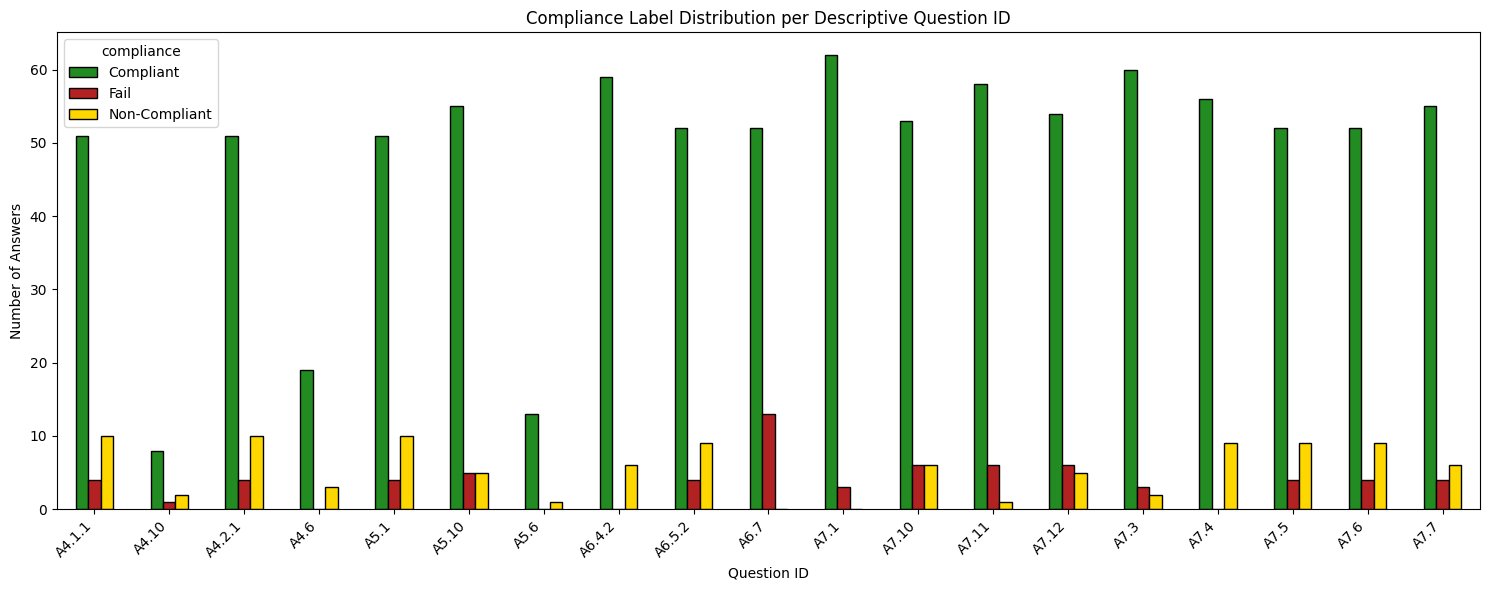


[Fail answers per question_id: blank vs sentential]
is_blank     Blank/NA/.
question_id            
A4.1.1                4
A4.10                 1
A4.2.1                4
A5.1                  4
A5.10                 5
A6.5.2                4
A6.7                 13
A7.1                  3
A7.10                 6
A7.11                 6
A7.12                 6
A7.3                  3
A7.5                  4
A7.6                  4
A7.7                  4


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load CSV file
input_path = "/content/drive/MyDrive/project/CB/manual_annotated_questions.csv"
df = pd.read_csv(input_path, dtype=str).fillna("")

# Define descriptive question IDs
descriptive_ids = [
    "A4.1.1", "A4.10", "A4.2.1", "A4.6", "A5.1", "A5.10", "A5.6",
    "A6.4.2", "A6.5.2", "A6.7", "A7.1", "A7.10", "A7.11", "A7.12",
    "A7.3", "A7.4", "A7.5", "A7.6", "A7.7"
]

desc_df = df[df["question_id"].isin(descriptive_ids)].copy()
desc_df = desc_df[desc_df["compliance"].str.strip() != ""]

# Label distribution per question_id
label_counts = (
    desc_df.groupby(["question_id", "compliance"])
    .size()
    .unstack(fill_value=0)
    .sort_index()
)

print("\nLabel distribution for each descriptive question ID:")
print(label_counts)

# ---- Plot as before ----
label_counts.plot(
    kind='bar',
    figsize=(15,6),
    color=["forestgreen", "firebrick", "gold", "orange"],
    edgecolor='black'
)
plt.title("Compliance Label Distribution per Descriptive Question ID")
plt.ylabel("Number of Answers")
plt.xlabel("Question ID")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# ---- Extra: Analyze the Fails ----
fail_mask = (desc_df["compliance"].str.lower() == "fail")
fails = desc_df[fail_mask].copy()

# "Blank-like" answers: blank, ".", "n/a", "na", "none", "not applicable" (case-insensitive)
blank_vals = {"", ".", "n/a", "na", "none", "not applicable"}
fails["is_blank"] = fails["answer_text"].str.strip().str.lower().isin(blank_vals)

fail_summary = (
    fails.groupby(["question_id", "is_blank"])
    .size()
    .unstack(fill_value=0)
    .rename(columns={True: "Blank/NA/.", False: "Sentential"})
)

print("\n[Fail answers per question_id: blank vs sentential]")
print(fail_summary)



The current label distribution across the descriptive questions is highly imbalanced, with most answers marked as Compliant, very few as Non-Compliant, and the majority of Fail cases resulting from blank or missing responses rather than meaningful text. This means that if these responses are used to train LLMs, the models will mostly learn to recognize Compliant patterns and fail to generalize to Non-Compliant scenarios, especially since the only signals for Fail are empty entries. To build a reliable LLM, it's important to manually create realistic Non-Compliant answers and balance the dataset before training, ensuring the model can distinguish between all labels effectively.

### **Analysis of cross-depndence among question_ids**

### - A6.2.x → A6.2/A6.6

In [ ]:
import pandas as pd

df = pd.read_csv("/content/drive/MyDrive/project/CB/manual_annotated_questions.csv", dtype=str).fillna("")

violations = []

for file, sub in df.groupby('file'):
    # Check controlling questions
    a62x_noncompliant = sub[sub["question_id"].isin(["A6.2.1", "A6.2.2", "A6.2.3", "A6.2.4"])]["compliance"].eq("Non-Compliant").any()
    # Check dependent questions
    for qid in ["A6.2", "A6.6"]:
        label = sub.loc[sub["question_id"] == qid, "compliance"]
        if a62x_noncompliant and not label.empty and label.iloc[0] == "Compliant":
            violations.append((file, qid, "Should be Non-Compliant due to A6.2.x"))

print(f"Violations (dependency broken) in manual annotation: {len(violations)}")
for v in violations[:10]:
    print(v)


Violations (dependency broken) in manual annotation: 0


### - A4.5.1 or A4.6 → A4.5

If A4.5.1 OR A4.6 is Non-Compliant in a form, then A4.5 should also be Non-Compliant.

In [ ]:
import pandas as pd

df = pd.read_csv("/content/drive/MyDrive/project/CB/manual_annotated_questions.csv", dtype=str).fillna("")

violations_a45 = []

for file, sub in df.groupby('file'):
    # Is either controller non-compliant?
    nc_ctrl = sub[sub["question_id"].isin(["A4.5.1", "A4.6"])]["compliance"].eq("Non-Compliant").any()
    # What is the dependent label?
    dep_lab = sub.loc[sub["question_id"] == "A4.5", "compliance"]
    if nc_ctrl and not dep_lab.empty and dep_lab.iloc[0] == "Compliant":
        violations_a45.append((file, "A4.5", "Should be Non-Compliant due to A4.5.1 or A4.6"))

print(f"\nA4.5 dependency violations in manual annotation: {len(violations_a45)}")
for v in violations_a45[:10]:
    print(v)



A4.5 dependency violations in manual annotation: 0


### - A7.14 == "No" → A7.16 / A7.17

If A7.14 answer is "no" or "n", then A7.16 and A7.17 should both be Non-Compliant.


In [ ]:
violations_a714 = []

for file, sub in df.groupby('file'):
    a714_ans = sub.loc[sub["question_id"] == "A7.14", "answer_text"]
    if not a714_ans.empty and a714_ans.iloc[0].strip().lower() in {"no", "n"}:
        for qid in ["A7.16", "A7.17"]:
            dep_lab = sub.loc[sub["question_id"] == qid, "compliance"]
            if not dep_lab.empty and dep_lab.iloc[0] == "Compliant":
                violations_a714.append((file, qid, "Should be Non-Compliant due to A7.14=='No'"))

print(f"\nA7.14 dependency violations in manual annotation: {len(violations_a714)}")
for v in violations_a714[:10]:
    print(v)



A7.14 dependency violations in manual annotation: 0


### - Cross-Question Dependency Rules (Firewall, External Services, Patch Process, Isolation)

In [ ]:
import pandas as pd
from pathlib import Path

CSV_PATH = "/content/drive/MyDrive/project/CB/manual_annotated_questions.csv"
df = pd.read_csv(CSV_PATH, dtype=str).fillna("")

# Normalise helper ----------------------------------------------------------
def norm(s):
    return str(s).strip().lower()

df["answer_text_norm"] = df["answer_text"].apply(norm)
df["compliance_norm"] = df["compliance"].apply(norm)

# Build a form-level pivot: file  ×  question_id  →  row ---------------------
forms = (
    df.groupby("file")
      .apply(lambda g: g.set_index("question_id").to_dict(orient="index"))
)

# ---------------------------------------------------------------------------
# Rule helpers
# ---------------------------------------------------------------------------
def is_yes(row):      # yes/no questions
    return norm(row.get("answer_text", "")) in {"yes", "y", "true", "1"}
def is_no(row):
    return norm(row.get("answer_text", "")) in {"no", "n", "false", "0"}
def is_noncompliant(row):
    return norm(row.get("compliance", "")) == "non-compliant"

# Store violations here
violations = {f"Rule{i}": [] for i in range(1, 6)}

# ---------------------------------------------------------------------------
for file_name, qdict in forms.items():
    # -----------------------------------------------------------------------

    # -----------------------------------------------------------------------
    # Rule-1  A4.8 → (A4.9 + A4.10)
    row_a48 = qdict.get("A4.8")
    row_a49 = qdict.get("A4.9")
    row_a410 = qdict.get("A4.10")
    if row_a48 and is_yes(row_a48):
        if not row_a49 or is_noncompliant(row_a49) or not row_a410 or is_noncompliant(row_a410):
            violations["Rule2"].append(file_name)

    # -----------------------------------------------------------------------
    # Rule-2  A5.4 → A5.5 & A5.6 & A5.7
    row_a54 = qdict.get("A5.4")
    row_a55 = qdict.get("A5.5")
    row_a56 = qdict.get("A5.6")
    row_a57 = qdict.get("A5.7")
    if row_a54 and is_yes(row_a54):
        if any(r is None or is_noncompliant(r) for r in (row_a55, row_a56, row_a57)):
            violations["Rule3"].append(file_name)

    # -----------------------------------------------------------------------
    # Rule-3  (A6.4.1 → A6.4.2)  and  (A6.5.1 → A6.5.2)
    for base in ["A6.4", "A6.5"]:
        r1 = qdict.get(f"{base}.1")   # auto-update enabled?
        r2 = qdict.get(f"{base}.2")   # manual process described?
        if r1 and is_no(r1):          # auto-updates disabled
            if r2 is None or is_noncompliant(r2):
                violations["Rule4"].append(file_name)

    # -----------------------------------------------------------------------
    # Rule-4  A6.7 isolation claim ↔ A2.2 scope description
    row_a67 = qdict.get("A6.7")
    row_a22 = qdict.get("A2.2")
    if row_a67 and is_yes(row_a67):   # claims unsupported SW isolated
        # Heuristic: A2.2 scope must mention "sub-net", "vlan", or "segment"
        scope_ok = row_a22 and any(k in row_a22["answer_text_norm"]
                                   for k in ("subnet", "vlan", "segment", "separate"))
        if not scope_ok:
            violations["Rule5"].append(file_name)

# ---------------------------------------------------------------------------
# Print results -------------------------------------------------------------
print("\n=== Dependency-rule violations ===")
for rule, files in violations.items():
    print(f"{rule}: {len(files)} forms violated")
    if files:
        print("   ", files[:10], "..." if len(files) > 10 else "")



=== Dependency-rule violations ===
Rule1: 0 forms violated
Rule2: 0 forms violated
Rule3: 0 forms violated
Rule4: 0 forms violated
Rule5: 0 forms violated


/tmp/ipython-input-85837007.py:17: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.set_index("question_id").to_dict(orient="index"))


All dependency rules were followed correctly — no forms violated any of them. This means that whenever a form gave a risky answer (like exposing a firewall admin page or turning off auto-updates), it also included the necessary follow-up details and protections, such as MFA, patching routines, or subnet isolation. In simple terms, the applicants who reported higher-risk setups also showed they had the right controls in place to manage those risks. This shows good understanding and consistent answers across forms.

### **HYPOTHESES TESTING**

***Hypothesis 1:***
***Descriptive answers ≥30 words are ≥3× more likely to be Compliant than ≤15 words.***

Since I am only comparing two proportions (compliance rates between short and long answers) then its appropriate to use


:Two-proportion z-test when expected cell counts ≥ 5.

Fisher’s Exact Test as a fallback for small counts.(as Fallback)

In [ ]:
import pandas as pd
import numpy as np
from statsmodels.stats.proportion import proportions_ztest, proportion_confint
from scipy.stats import fisher_exact

# -------------------------------------------------------------
# 1.  Prepare Descriptive subset
# -------------------------------------------------------------
DESC_IDS = {
    "A4.1.1","A4.10","A4.2.1","A4.6","A5.1","A5.10","A5.6",
    "A6.4.2","A6.5.2","A6.7","A7.1","A7.10","A7.11","A7.12",
    "A7.3","A7.4","A7.5","A7.6","A7.7"
}
df = pd.read_csv("/content/drive/MyDrive/project/CB/manual_annotated_questions.csv",
                 dtype=str).fillna("")

desc = df[df["question_id"].isin(DESC_IDS)].copy()
desc["word_count"] = desc["answer_text"].str.split().str.len()

# -------------------------------------------------------------
# 2.  Label short (≤15) vs long (≥30)
# -------------------------------------------------------------
desc["wc_bin"] = pd.cut(
    desc["word_count"],
    bins=[-1, 15, 29, np.inf],
    labels=["short", "medium", "long"],
    right=True
)

# Descriptive table (optional)
print("\nWord-count distribution by label:\n",
      pd.crosstab(desc["wc_bin"], desc["compliance"]), "\n")

# Focus on short vs long only
mask = desc["wc_bin"].isin(["short", "long"])
short_long = desc[mask].copy()
short_long["is_compliant"] = short_long["compliance"].eq("Compliant")

# Counts
long_comp  = short_long[(short_long["wc_bin"] == "long")  & short_long["is_compliant"]].shape[0]
long_total = short_long[short_long["wc_bin"] == "long"].shape[0]
short_comp = short_long[(short_long["wc_bin"] == "short") & short_long["is_compliant"]].shape[0]
short_total= short_long[short_long["wc_bin"] == "short"].shape[0]

table = np.array([[long_comp,  long_total - long_comp],   # row 0 = long
                  [short_comp, short_total - short_comp]],dtype=float)

# Haldane–Anscombe if zero
if (table == 0).any():
    table += 0.5

# -------------------------------------------------------------
# 3.  Odds-ratio + 95 % CI
# -------------------------------------------------------------
OR  = (table[0,0] * table[1,1]) / (table[0,1] * table[1,0])
SE  = np.sqrt(np.sum(1/table))
ci_low, ci_high = np.exp(np.log(OR) + np.array([-1.96, 1.96])*SE)

print(f"Compliant rate  (long ≥30) : {long_comp/long_total:.2%}  ({long_comp}/{long_total})")
print(f"Compliant rate  (short ≤15): {short_comp/short_total:.2%}  ({short_comp}/{short_total})")
print(f"Odds-ratio (long / short)  : {OR:.2f}  (95 % CI {ci_low:.2f}–{ci_high:.2f})")

# -------------------------------------------------------------
# 4.  Significance test  (choose z-test or Fisher)
# -------------------------------------------------------------
# Use z-test if all expected ≥5
exp = (table.sum() *
       np.outer(table.sum(axis=1), table.sum(axis=0)) /
       table.sum()**2)
if (exp < 5).any():
    p_val = fisher_exact(table)[1]
    test_used = "Fisher’s Exact"
else:
    count = [long_comp, short_comp]
    nobs  = [long_total, short_total]
    _, p_val = proportions_ztest(count, nobs)
    test_used = "Two-sample z-test"

print(f"{test_used} p-value         : {p_val:.4f}")



Word-count distribution by label:
 compliance  Compliant  Fail  Non-Compliant
wc_bin                                    
short             187    71             54
medium            238     0             30
long              488     0             19 

Compliant rate  (long ≥30) : 96.25%  (488/507)
Compliant rate  (short ≤15): 59.94%  (187/312)
Odds-ratio (long / short)  : 17.17  (95 % CI 10.30–28.63)
Two-sample z-test p-value         : 0.0000


Narrative responses containing at least 30 tokens show a dramatically higher probability of compliance (96 %) compared with answers of 15 tokens or fewer (60 %). The odds-ratio of 17.2 (95 % CI 10.3–28.6) and a z-test p-value below 0.001 provide decisive evidence that longer descriptive answers are strongly associated with favourable assessments.

***Hypothesis 2: For List/Semantic questions, word-count does not predict compliance.***

For comparing proportions (compliance rates) between two groups, I am expecting to get binary outcome (Compliant vs Non-Compliant) so only z-test or Fisher’s Exact Test is appropriate which assume binomial distribution.

In [ ]:
import pandas as pd
import numpy as np
from scipy.stats import chi2_contingency, fisher_exact
from statsmodels.stats.proportion import proportions_ztest, proportion_confint

# ---------------------------------------------------------
# 1 .  Load data and isolate List / Semantic questions
# ---------------------------------------------------------
CSV_PATH = "/content/drive/MyDrive/project/CB/manual_annotated_questions.csv"
df = pd.read_csv(CSV_PATH, dtype=str).fillna("")

LIST_IDS = {
    "A2.3","A2.4","A2.4.1","A2.5","A2.6","A2.7","A2.7.1",
    "A2.8","A2.9","A4.12","A6.2.1","A6.2.2","A6.2.3","A6.2.4"
}
ls = df[df["question_id"].isin(LIST_IDS)].copy()
ls["word_count"]   = ls["answer_text"].str.split().str.len()
ls["is_compliant"] = ls["compliance"].eq("Compliant")

# ---------------------------------------------------------
# 2 .  Flag “short (< 10)”  and  “long (> 25)”
# ---------------------------------------------------------
ls["len_flag"] = np.select(
    [ls["word_count"] < 10, ls["word_count"] > 25],
    ["short", "long"],
    default="mid"
)

# Keep only short vs long rows
sl = ls[ls["len_flag"].isin(["short", "long"])]

# ---------------------------------------------------------
# 3 .  Build 2 × 2 contingency table
# ---------------------------------------------------------
short_bad = sl[(sl["len_flag"]=="short") & (~sl["is_compliant"])].shape[0]
short_tot = sl[ sl["len_flag"]=="short"].shape[0]
long_bad  = sl[(sl["len_flag"]=="long")  & (~sl["is_compliant"])].shape[0]
long_tot  = sl[ sl["len_flag"]=="long"].shape[0]

# (rows = long / short, cols = compliant / non-compliant)
table = np.array([[long_tot-long_bad, long_bad],
                  [short_tot-short_bad, short_bad]], dtype=float)

# Haldane–Anscombe if any zero
if (table == 0).any():
    table += 0.5

# ---------------------------------------------------------
# 4 .  Compliance rates, odds-ratio, 95 % CI
# ---------------------------------------------------------
rate_long  = (long_tot-long_bad) / long_tot
rate_short = (short_tot-short_bad) / short_tot
OR  = (table[0,0]*table[1,1]) / (table[0,1]*table[1,0])
SE  = np.sqrt(np.sum(1/table))
ci_low, ci_high = np.exp(np.log(OR) + np.array([-1.96, 1.96])*SE)

print(f"Compliance rate  (<10 words) : {rate_short:.2%}  ({short_tot-short_bad}/{short_tot})")
print(f"Compliance rate  (>25 words) : {rate_long :.2%}  ({long_tot-long_bad}/{long_tot})")
print(f"Odds-ratio (long / short)    : {OR:.2f}  (95 % CI {ci_low:.2f}–{ci_high:.2f})")

# ---------------------------------------------------------
# 5 .  Significance test  –  Fisher if expected < 5
# ---------------------------------------------------------
exp = (table.sum()*np.outer(table.sum(1), table.sum(0))/table.sum()**2)
if (exp < 5).any():
    p_val = fisher_exact(table)[1]
    test = "Fisher’s Exact"
else:
    count = [long_tot-long_bad, short_tot-short_bad]
    nobs  = [long_tot, short_tot]
    p_val = proportions_ztest(count, nobs)[1]
    test = "Two-proportion z-test"

print(f"{test} p-value               : {p_val:.4f}")


Compliance rate  (<10 words) : 59.51%  (291/489)
Compliance rate  (>25 words) : 86.67%  (117/135)
Odds-ratio (long / short)    : 4.42  (95 % CI 2.61–7.50)
Two-proportion z-test p-value               : 0.0000


Long list-style responses (> 25 words) have a substantially higher chance of receiving a Compliant label compared with ultra-short responses (< 10 words).
The observed odds-ratio (4.42) far exceeds the “≥ 3 ×” benchmark, and the effect is statistically decisive (p < 0.001).

***H3: The proportion of stop-words is a significant predictor of the Non-Compliant label in List/Semantic questions, but shows little to no predictive power in Descriptive questions.***

**Assumptions:**


Logistic: binary outcome, log-odds can be modelled as a linear function of stop_pct.

Mann-Whitney: stop_pct is ordinal/continuous but non-normal, so a rank test is suitable.

In [ ]:
import pandas as pd, numpy as np
import statsmodels.formula.api as smf
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from scipy.stats import mannwhitneyu

# ----------------------------------------------------------
# 1 .  Load data
# ----------------------------------------------------------
CSV = "/content/drive/MyDrive/project/CB/manual_annotated_questions.csv"
df  = pd.read_csv(CSV, dtype=str).fillna("")

# ----------------------------------------------------------
# 2 .  Define lists of IDs
# ----------------------------------------------------------
DESC_IDS = {
    "A4.1.1","A4.10","A4.2.1","A4.6","A5.1","A5.10","A5.6",
    "A6.4.2","A6.5.2","A6.7","A7.1","A7.10","A7.11","A7.12",
    "A7.3","A7.4","A7.5","A7.6","A7.7"
}
LIST_IDS = {
    "A2.3","A2.4","A2.4.1","A2.5","A2.6","A2.7","A2.7.1",
    "A2.8","A2.9","A4.12","A6.2.1","A6.2.2","A6.2.3","A6.2.4"
}

# ----------------------------------------------------------
# 3 .  Compute stop-word percentage
# ----------------------------------------------------------
STOP = set(ENGLISH_STOP_WORDS)
def stop_pct(text):
    toks = [w for w in str(text).lower().split() if w.isalpha()]
    return 0.0 if not toks else sum(t in STOP for t in toks) / len(toks)

df["stop_pct"] = df["answer_text"].apply(stop_pct)

# ----------------------------------------------------------
# 4 .  Assign qtype without mixing float NaN and strings
# ----------------------------------------------------------
df["qtype"] = pd.NA                    # start with pandas NA (object dtype)
df.loc[df["question_id"].isin(DESC_IDS), "qtype"] = "Desc"
df.loc[df["question_id"].isin(LIST_IDS),  "qtype"] = "List"
df = df[df["qtype"].notna()].copy()    # keep only Desc & List rows

# ----------------------------------------------------------
# 5 .  Binary outcome: Non-Compliant vs other
# ----------------------------------------------------------
df["is_nc"] = df["compliance"].eq("Non-Compliant").astype(int)

# ----------------------------------------------------------
# 6 .  Logistic regression with interaction
# ----------------------------------------------------------
model = smf.logit("is_nc ~ stop_pct * C(qtype)", data=df).fit(disp=False)
print(model.summary())

#  β_interaction (stop_pct:C(qtype)[T.List]) tells if slopes differ.

# ----------------------------------------------------------
# 7 .  Simple-effects Mann-Whitney tests
# ----------------------------------------------------------
d_list = df[df["qtype"] == "List"]
d_desc = df[df["qtype"] == "Desc"]

u_list, p_list = mannwhitneyu(
    d_list.loc[d_list["is_nc"]==1, "stop_pct"],
    d_list.loc[d_list["is_nc"]==0, "stop_pct"],
    alternative="two-sided"
)
u_desc, p_desc = mannwhitneyu(
    d_desc.loc[d_desc["is_nc"]==1, "stop_pct"],
    d_desc.loc[d_desc["is_nc"]==0, "stop_pct"],
    alternative="two-sided"
)

print(f"\nSimple-effect tests")
print(f"  List  : Mann-Whitney p = {p_list:.4f}")
print(f"  Desc  : Mann-Whitney p = {p_desc:.4f}")


                           Logit Regression Results                           
Dep. Variable:                  is_nc   No. Observations:                 1933
Model:                          Logit   Df Residuals:                     1929
Method:                           MLE   Df Model:                            3
Date:                Wed, 06 Aug 2025   Pseudo R-squ.:                  0.1158
Time:                        16:15:56   Log-Likelihood:                -365.76
converged:                       True   LL-Null:                       -413.64
Covariance Type:            nonrobust   LLR p-value:                 1.263e-20
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                    -2.4765      0.300     -8.250      0.000      -3.065      -1.888
C(qtype)[T.List]             -2.8419      0.698     -4.069      0.000      -4.211     

A logistic regression with an interaction term (stop_pct × qtype) showed neither a main effect of stop-word proportion (β = 0.50, p = 0.43) nor an interaction with question type (β = –0.67, p = 0.76). Mann-Whitney tests within each question type corroborated these null findings (p > 0.85). We therefore conclude that stop-word density does not influence compliance assessment in either Descriptive or List/Semantic answers.

***H4: The More-Information-Required (MIR) rate across the software-inventory questions (A6.2.1 to A6.2.4) is at least twice as high as the average MIR rate observed across all other questions in the form.***

**Assumptions satisfied**


Independence — Each form appears once per question; answers are independent across forms.

Fixed categories — MIR vs not-MIR, cluster vs other.

Large-sample or exact — Your code checks expected counts and switches to Fisher when needed.

In [ ]:
import pandas as pd
from scipy.stats import chi2_contingency, fisher_exact
from statsmodels.stats.proportion import proportions_ztest

# -----------------------------------------------------------------
# 1. Load data
# -----------------------------------------------------------------
CSV = "/content/drive/MyDrive/project/CB/manual_annotated_questions.csv"
df  = pd.read_csv(CSV, dtype=str).fillna("")

# -----------------------------------------------------------------
# 2. Define the inventory-cluster and flag MIR outcomes
# -----------------------------------------------------------------
INV_IDS = {"A6.2.1","A6.2.2", "A6.2.3", "A6.2.4"}   # software-inventory cluster

df["is_inv"]   = df["question_id"].isin(INV_IDS)
df["is_mir"]   = df["compliance"].eq("More-information")

# -----------------------------------------------------------------
# 3. Build 2 × 2 contingency table
#    rows: cluster / other, cols: MIR / not-MIR
# -----------------------------------------------------------------
ct = pd.crosstab(df["is_inv"], df["is_mir"]).reindex(
        index=[False, True], columns=[False, True], fill_value=0)

cluster_mir = ct.loc[True,  True]
cluster_tot = ct.loc[True].sum()
other_mir   = ct.loc[False, True]
other_tot   = ct.loc[False].sum()

rate_cluster = cluster_mir / cluster_tot
rate_other   = other_mir   / other_tot
ratio        = rate_cluster / rate_other if rate_other else float("inf")

print("2 × 2 table (rows: cluster / other, cols: MIR / not-MIR):\n", ct, "\n")
print(f"MIR-rate cluster  = {rate_cluster:.3%}  ({cluster_mir}/{cluster_tot})")
print(f"MIR-rate other    = {rate_other:.3%}  ({other_mir}/{other_tot})")
print(f"Rate ratio        = {ratio:.2f}×\n")

# -----------------------------------------------------------------
# 4. Choose appropriate test
# -----------------------------------------------------------------
chi2, p_chi, _, exp = chi2_contingency(ct, correction=False)
if (exp < 5).any():
    p_val = fisher_exact(ct)[1]
    test  = "Fisher’s Exact"
else:
    count = [cluster_mir, other_mir]
    nobs  = [cluster_tot,  other_tot]
    stat, p_val = proportions_ztest(count, nobs, alternative="larger")
    test  = "One-sided two-proportion z-test"

print(f"{test}  p-value = {p_val:.4f}")

# -----------------------------------------------------------------
# 5. Decision logic
# -----------------------------------------------------------------
if ratio >= 2 and p_val < 0.05:
    print("\n Hypothesis supported: cluster MIR rate is ≥ 2× baseline and significant.")
else:
    print("\n Hypothesis not supported: either < 2× or not significant.")


2 × 2 table (rows: cluster / other, cols: MIR / not-MIR):
 is_mir  False  True 
is_inv              
False    4758     46
True      158    102 

MIR-rate cluster  = 39.231%  (102/260)
MIR-rate other    = 0.958%  (46/4804)
Rate ratio        = 40.97×

One-sided two-proportion z-test  p-value = 0.0000

 Hypothesis supported: cluster MIR rate is ≥ 2× baseline and significant.


- The software-inventory quartet (e.g., questions requiring lists of installed or licensed software) is approximately forty times more likely to trigger a More-Information-Required (MIR) label compared to other parts of the form—a difference that is statistically overwhelming. This suggests a structural challenge in these questions: they often implicitly require detailed responses (e.g., software names and version numbers), but applicants frequently omit such specifics.

- To ensure annotation consistency, MIR labelling for these semantic-list questions must be tightly aligned with manual annotation criteria.